In [1]:
from io import BytesIO
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl

from feature_utils import normalize_histogram

In [2]:
# Read the parquet file, this takes a while. Leave it here
features_file = Path("data/train_features.parquet")
if not features_file.exists():
    print("No features file found. Please run the create_features_table first")
    exit(1)

dft = pl.read_parquet(features_file, use_pyarrow=True, memory_map=True)

Class 0
Class 0 has samples: 210


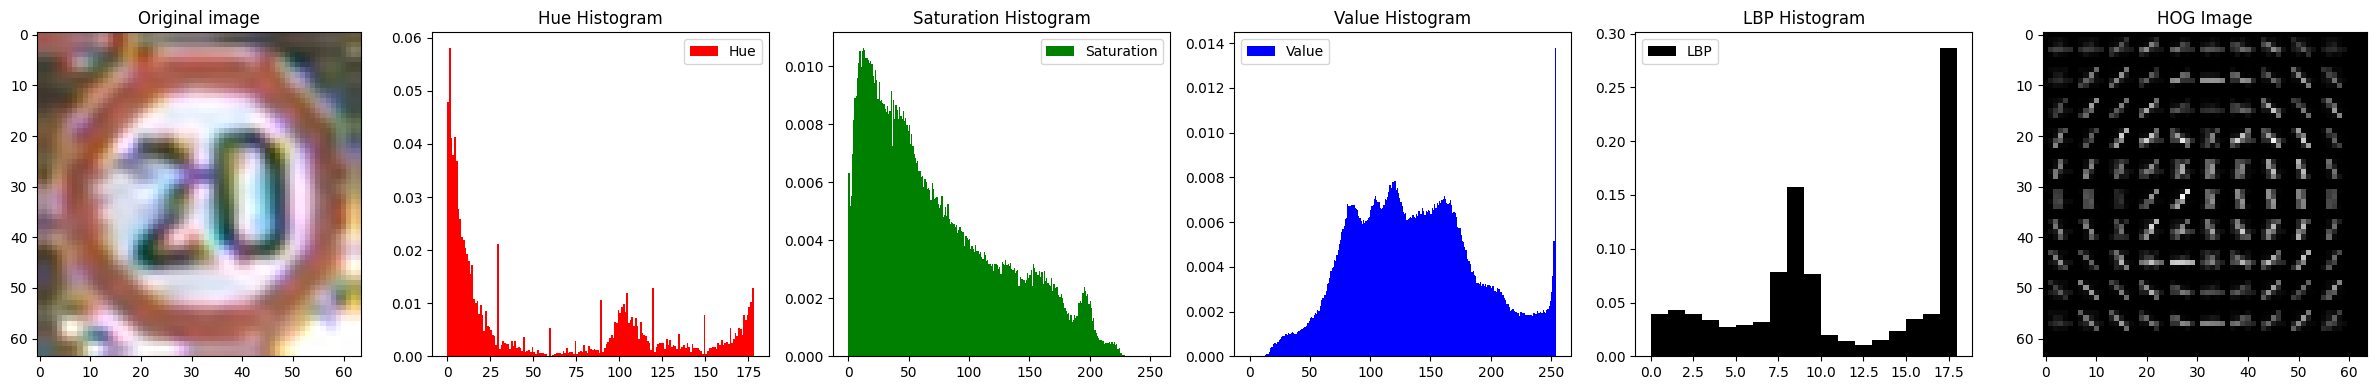

Class 1
Class 1 has samples: 2220


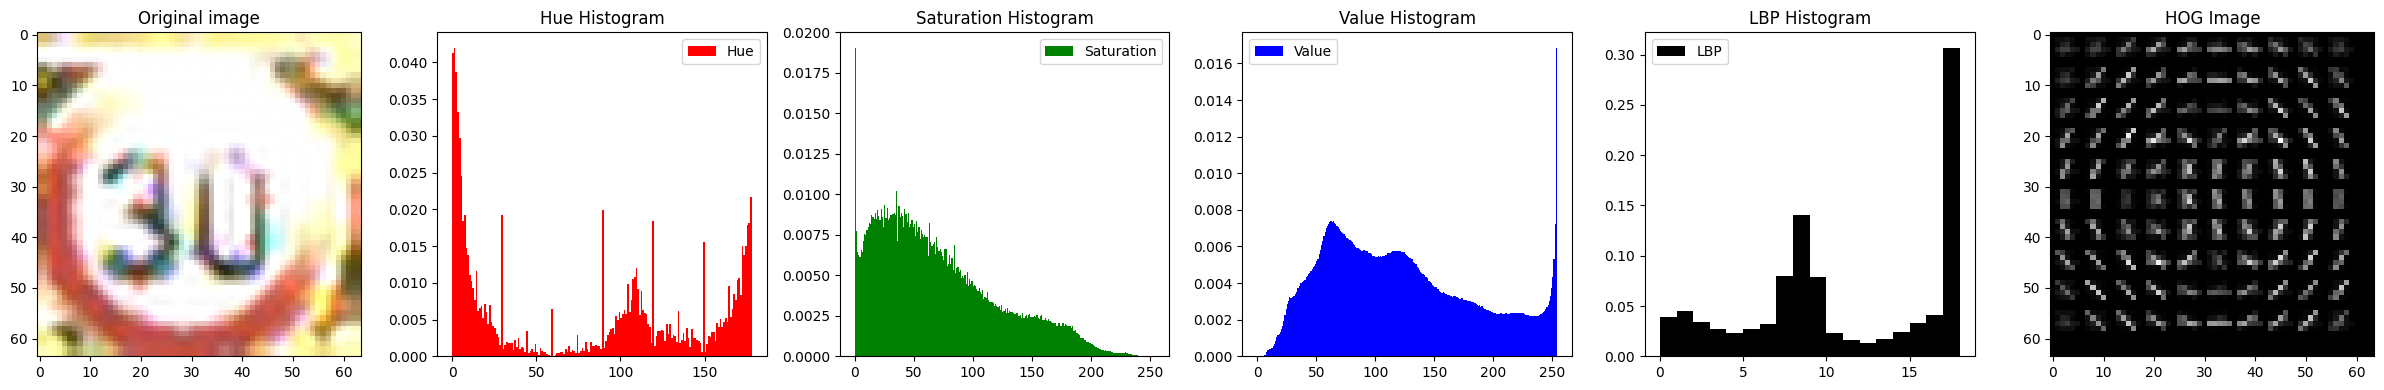

Class 2
Class 2 has samples: 2250


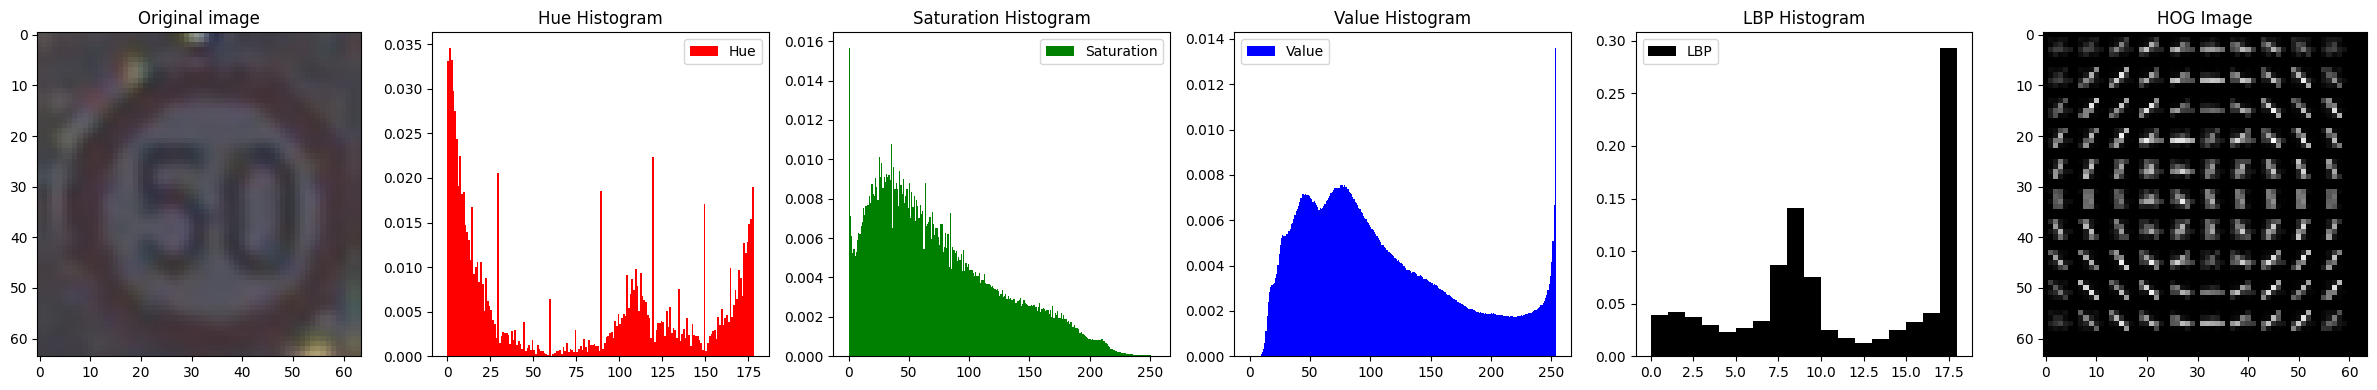

Class 3
Class 3 has samples: 1410


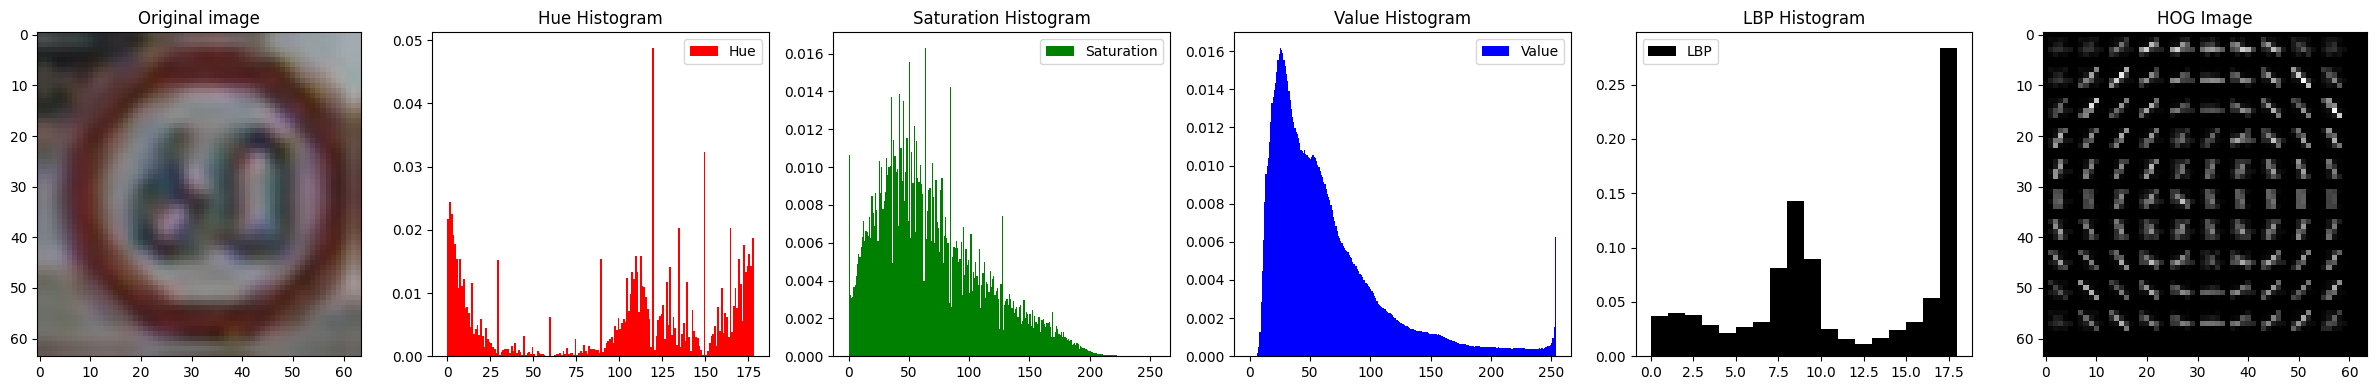

Class 4
Class 4 has samples: 1980


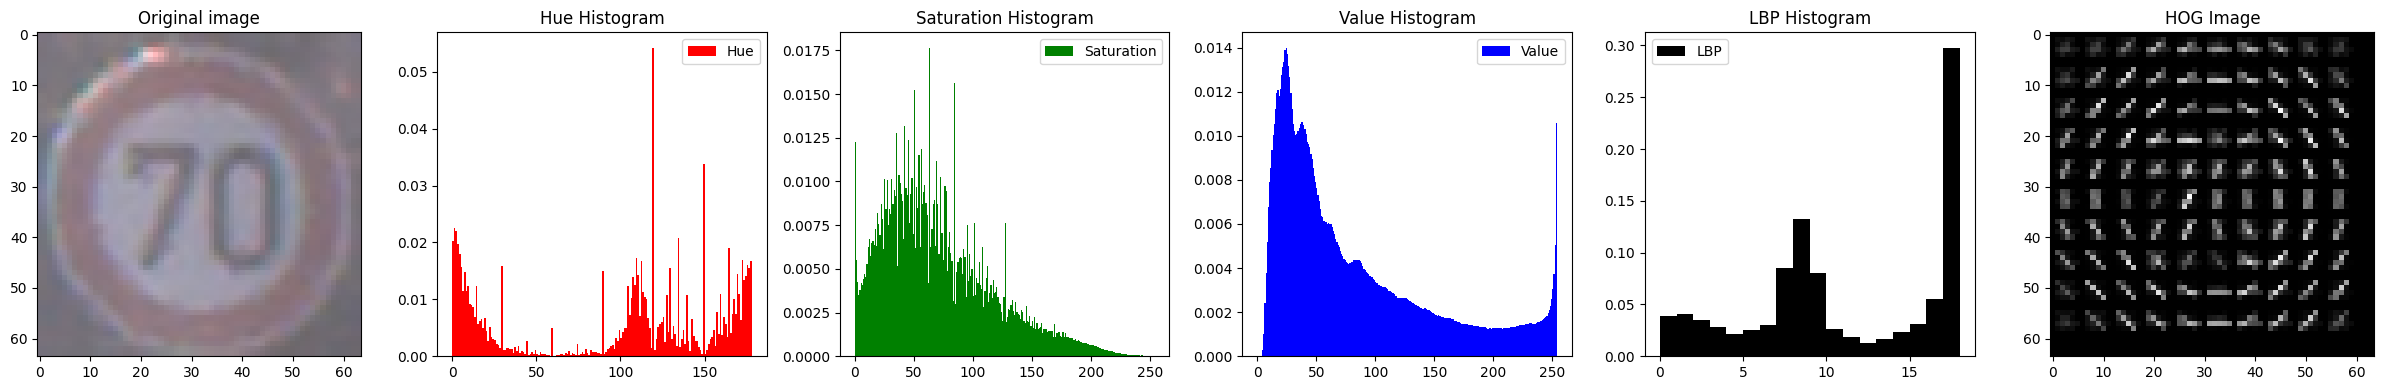

Class 5
Class 5 has samples: 1860


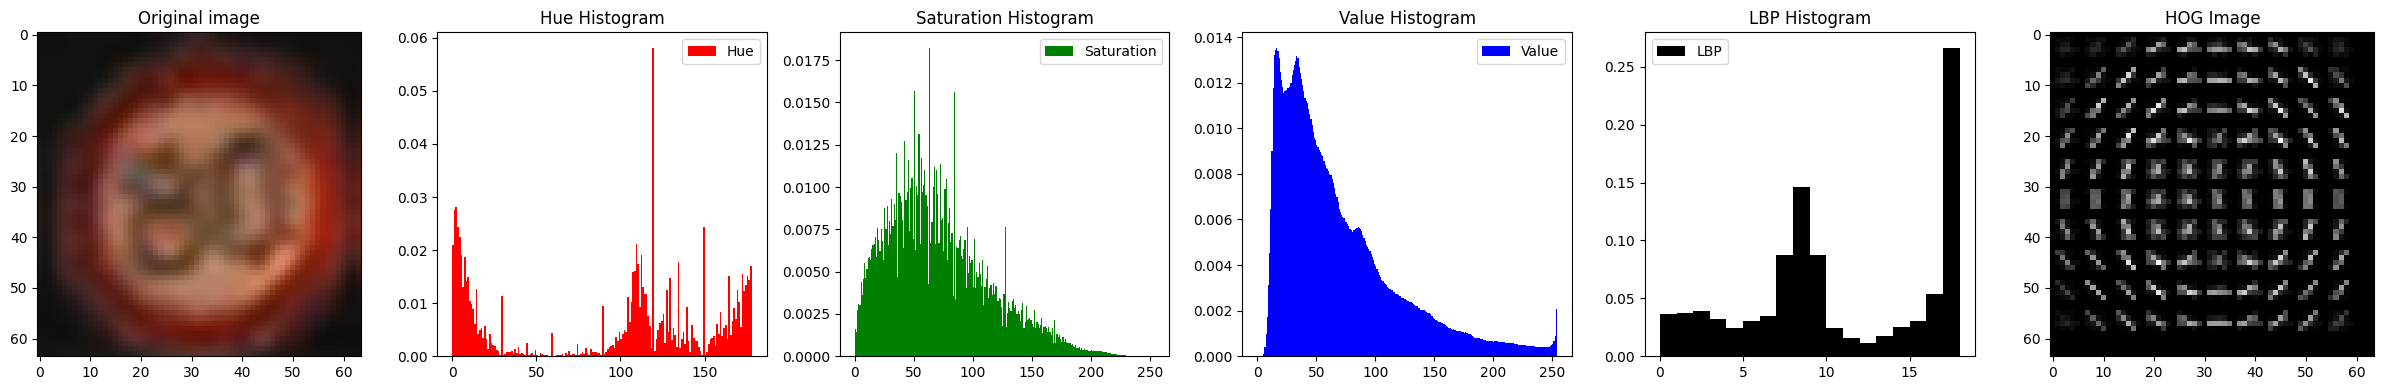

Class 6
Class 6 has samples: 420


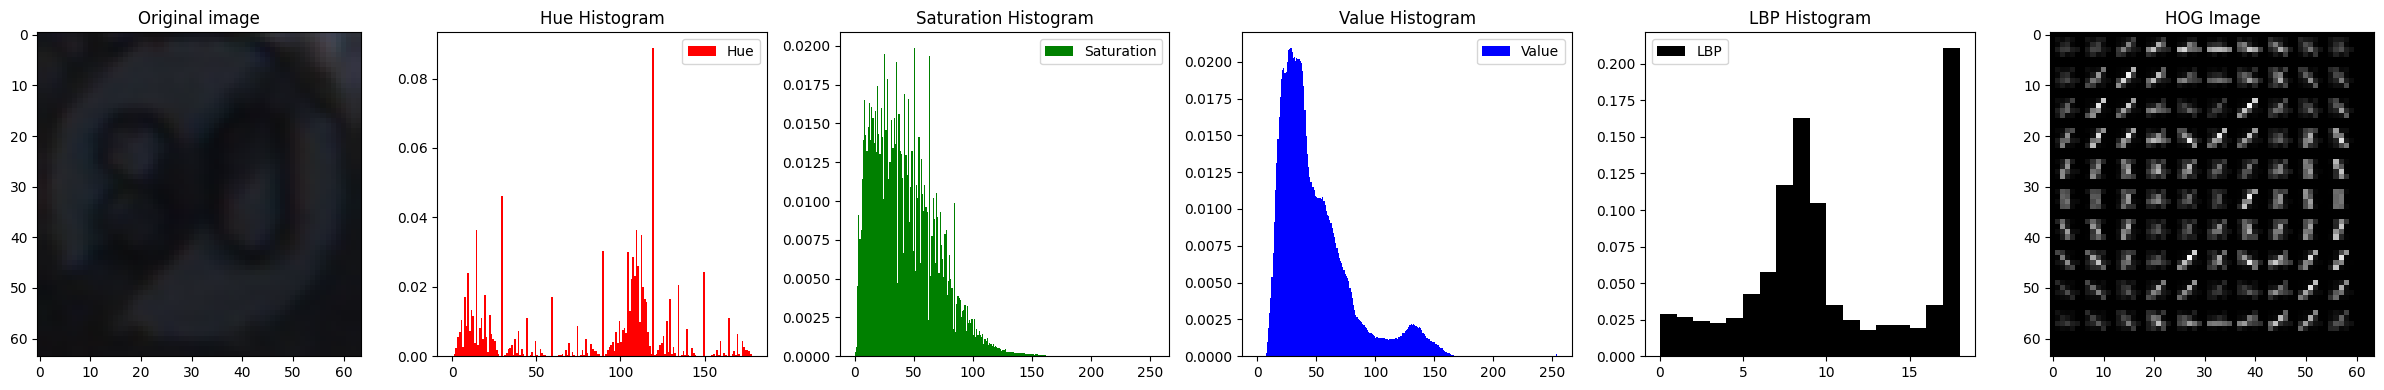

Class 7
Class 7 has samples: 1440


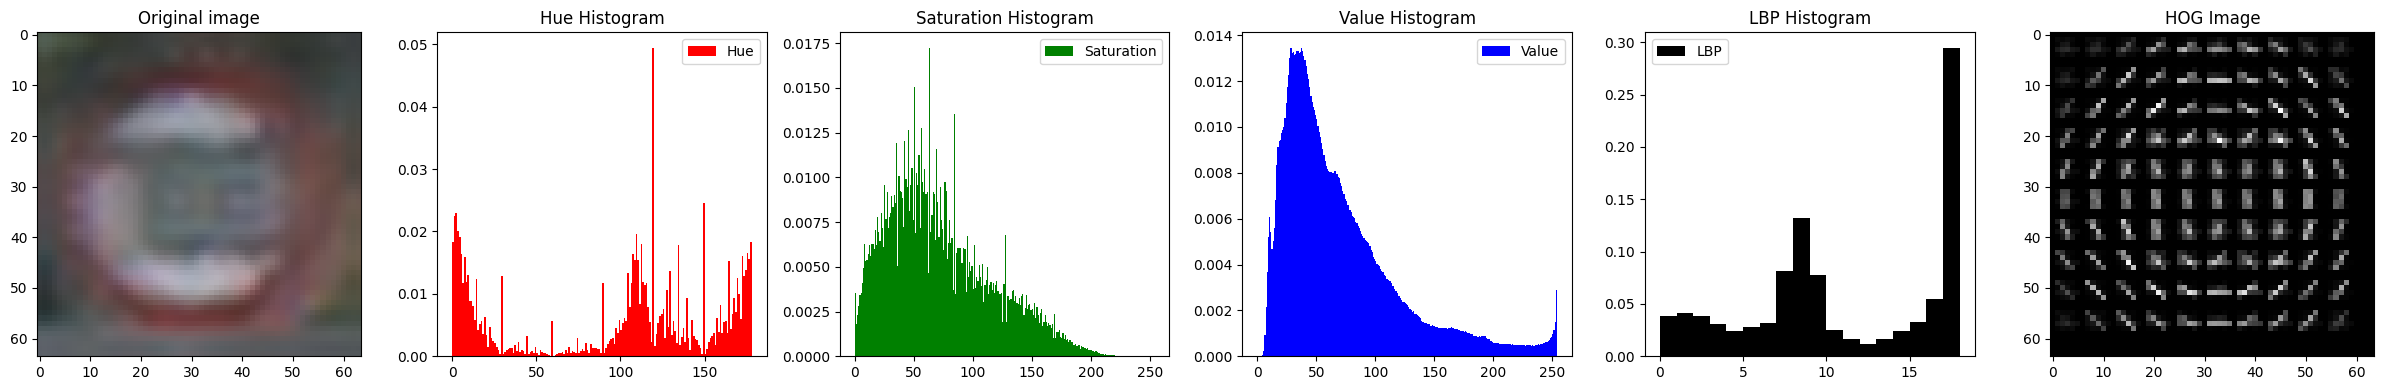

Class 8
Class 8 has samples: 1410


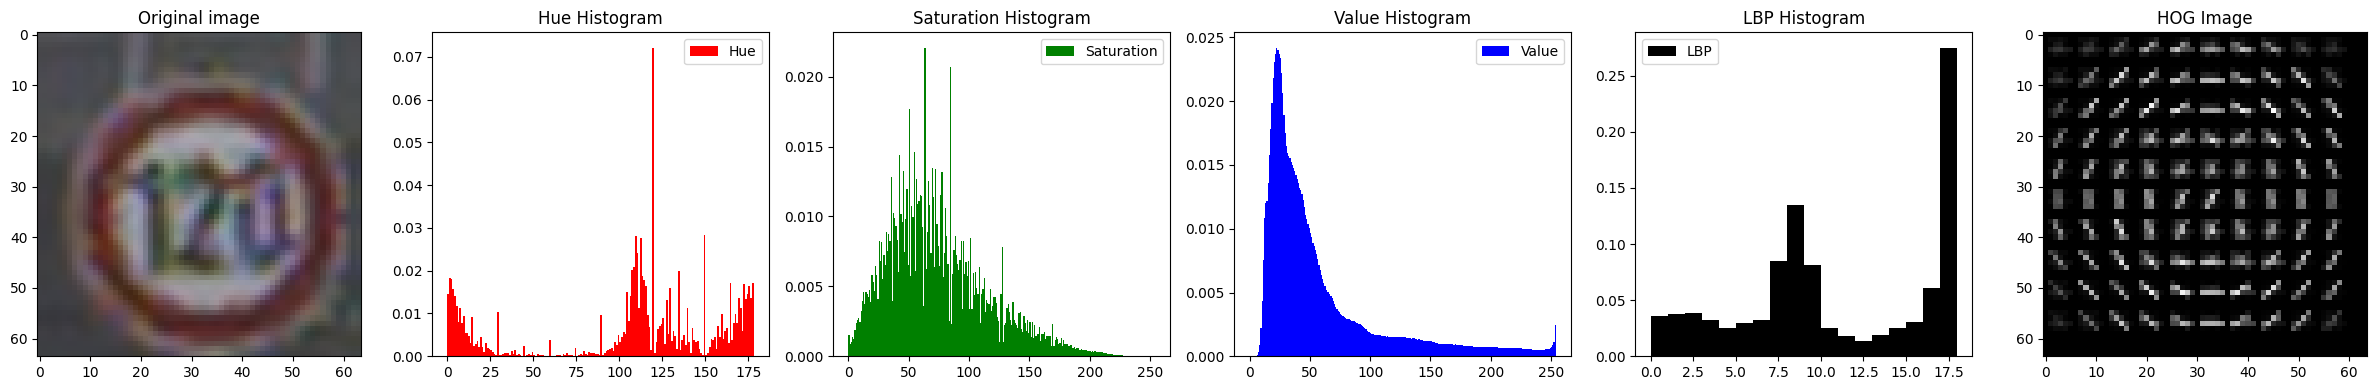

Class 9
Class 9 has samples: 1470


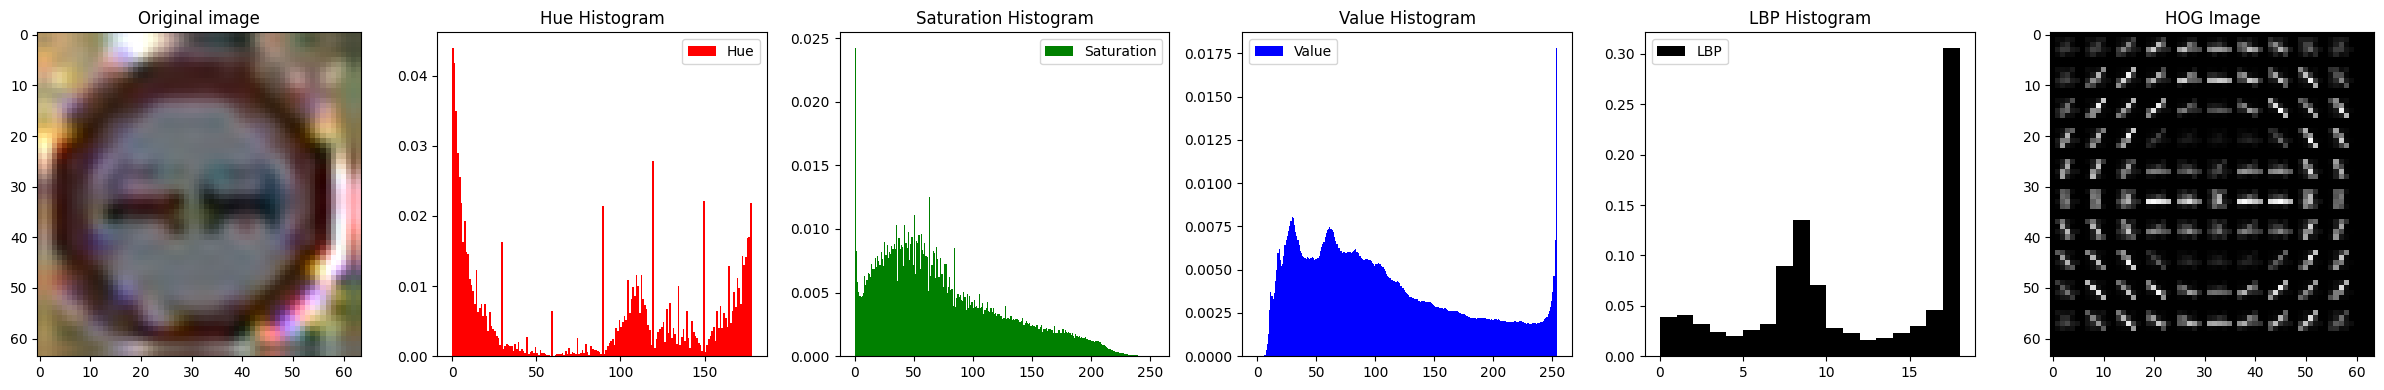

Class 10
Class 10 has samples: 2010


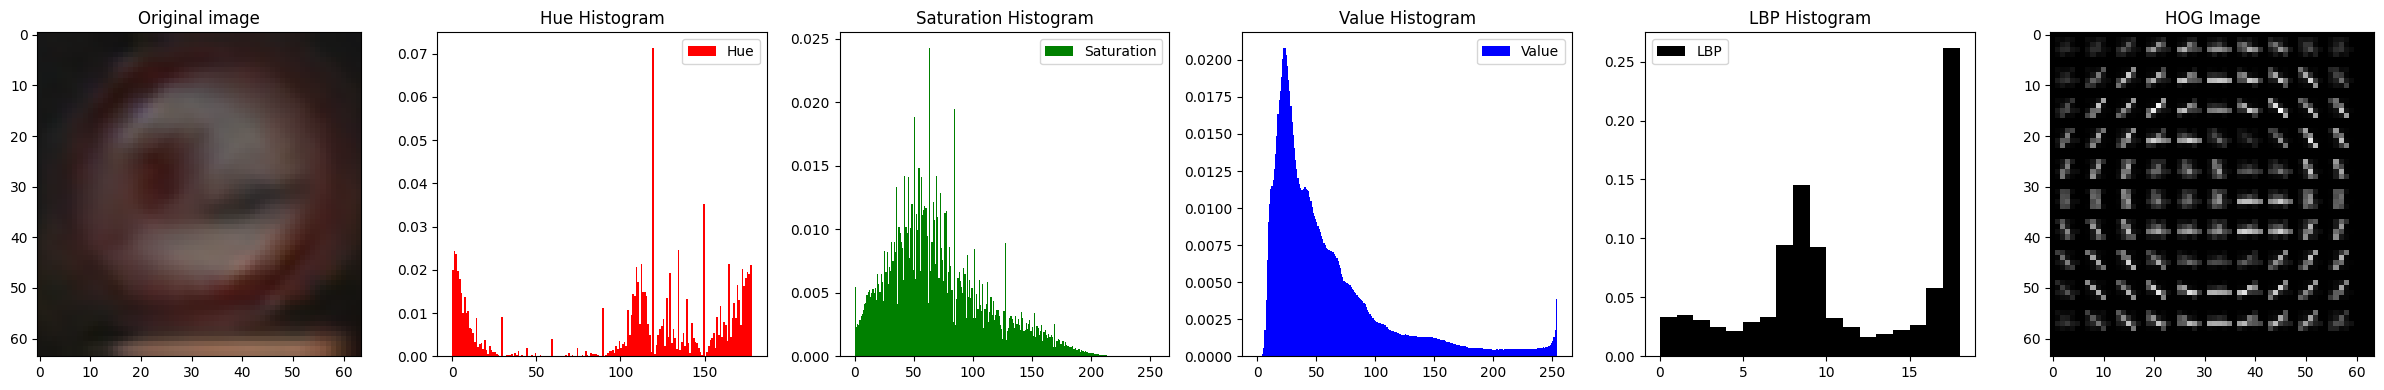

Class 11
Class 11 has samples: 1320


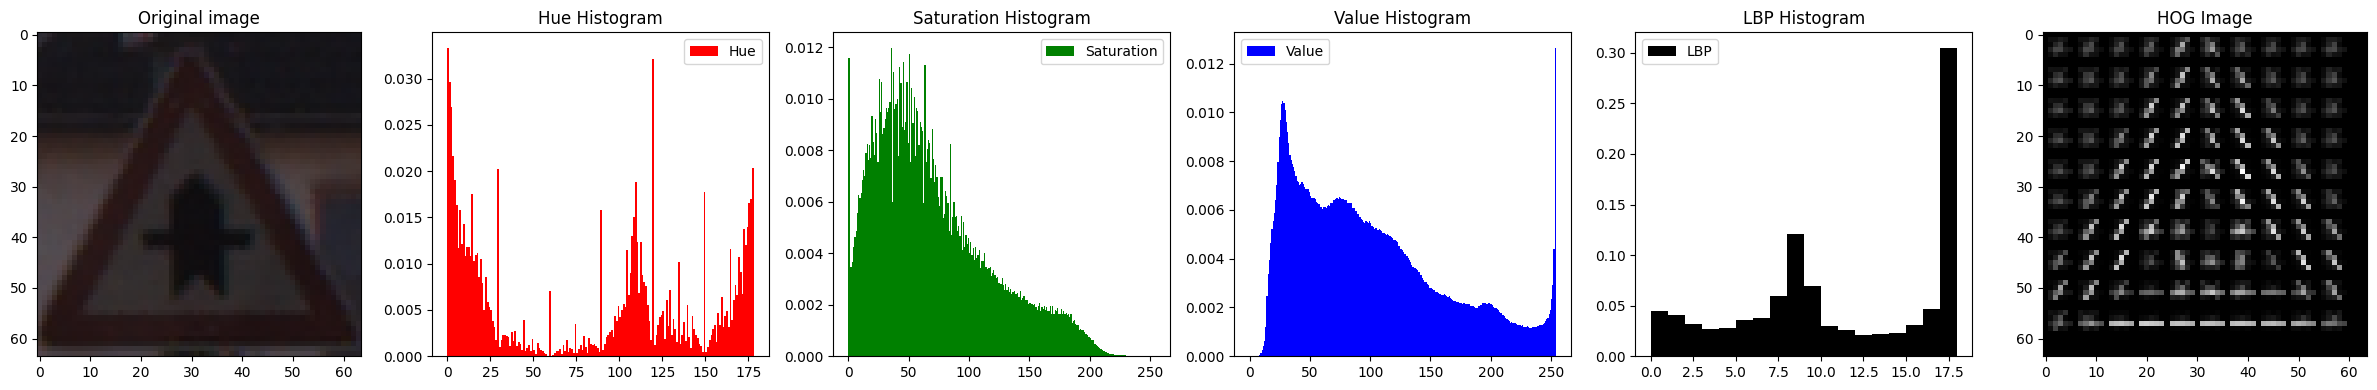

Class 12
Class 12 has samples: 2100


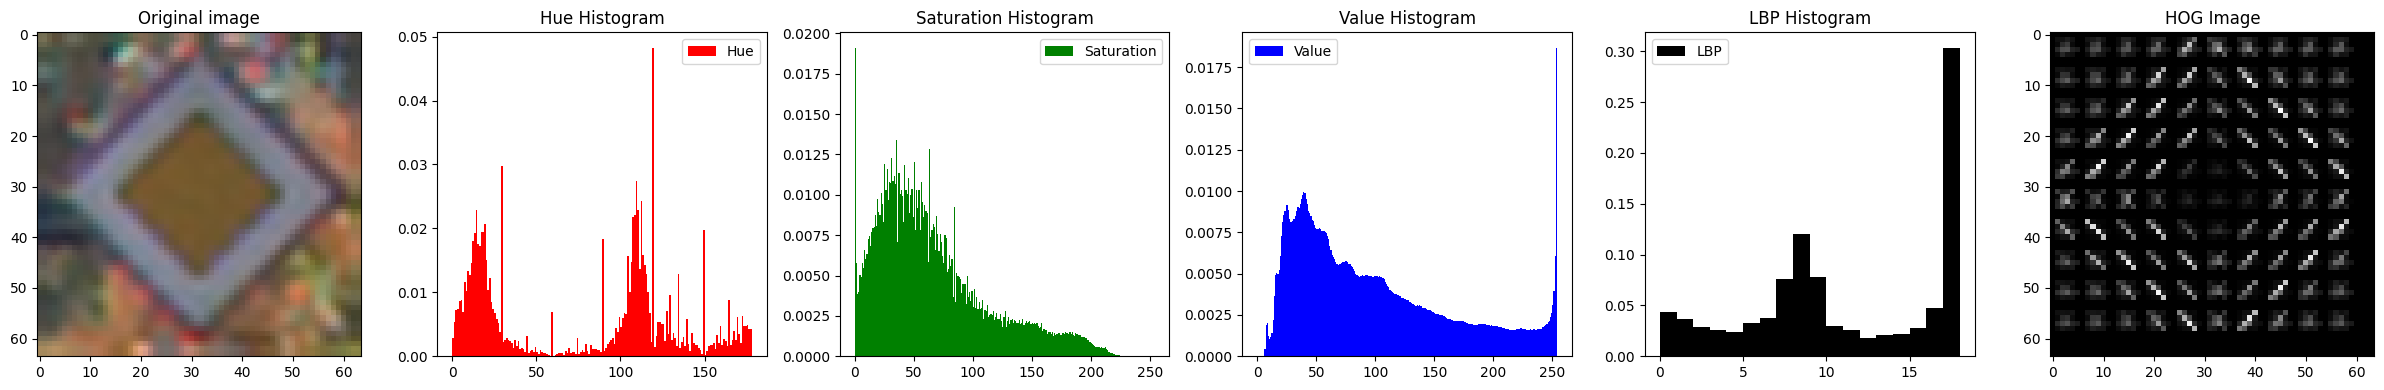

Class 13
Class 13 has samples: 2160


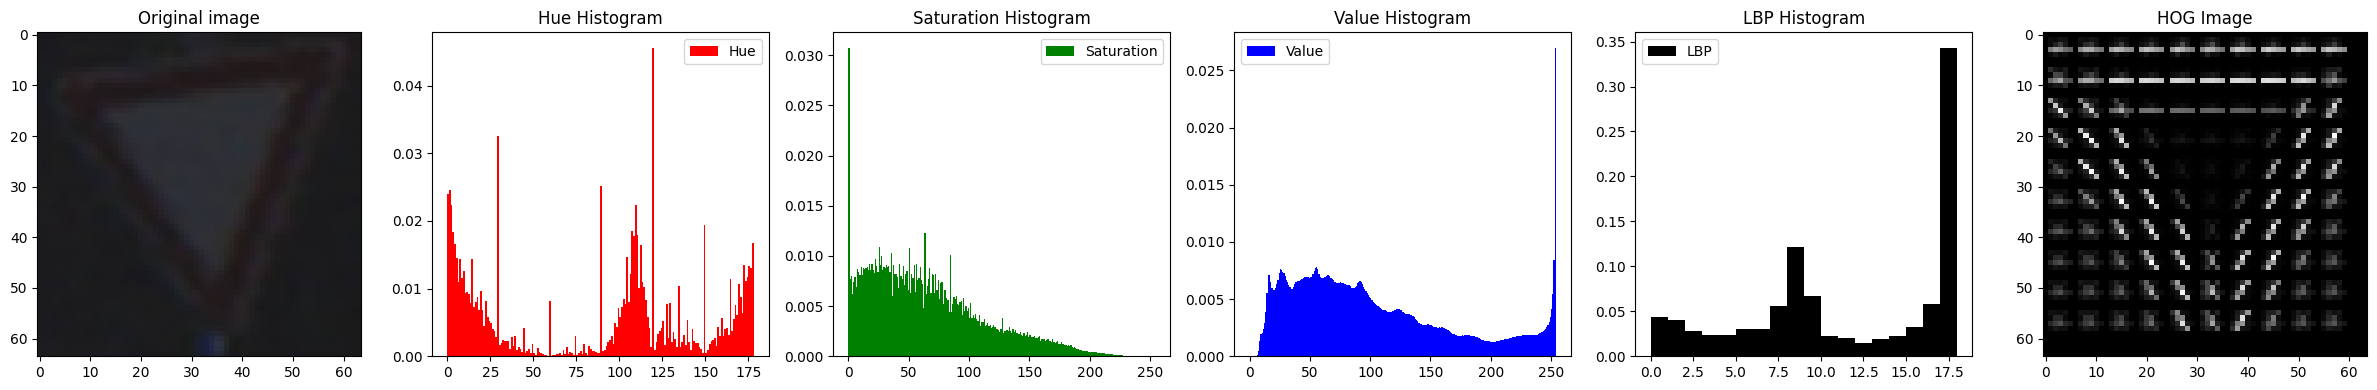

Class 14
Class 14 has samples: 780


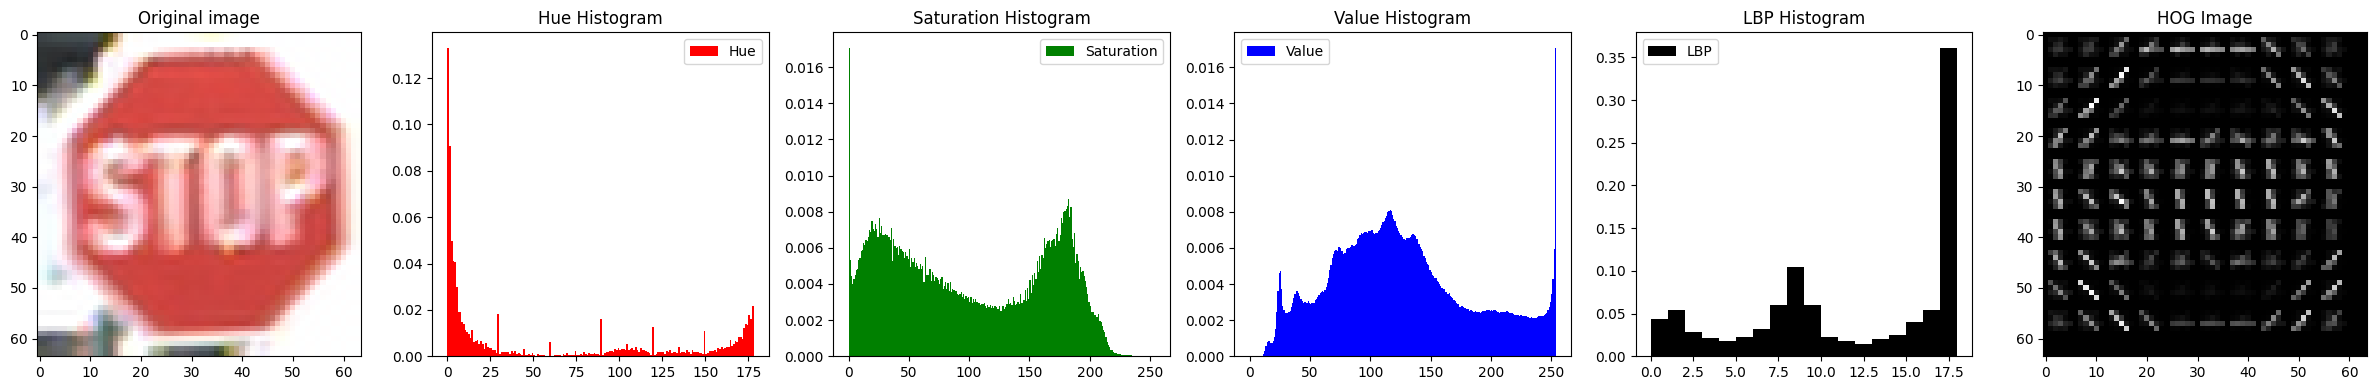

Class 15
Class 15 has samples: 630


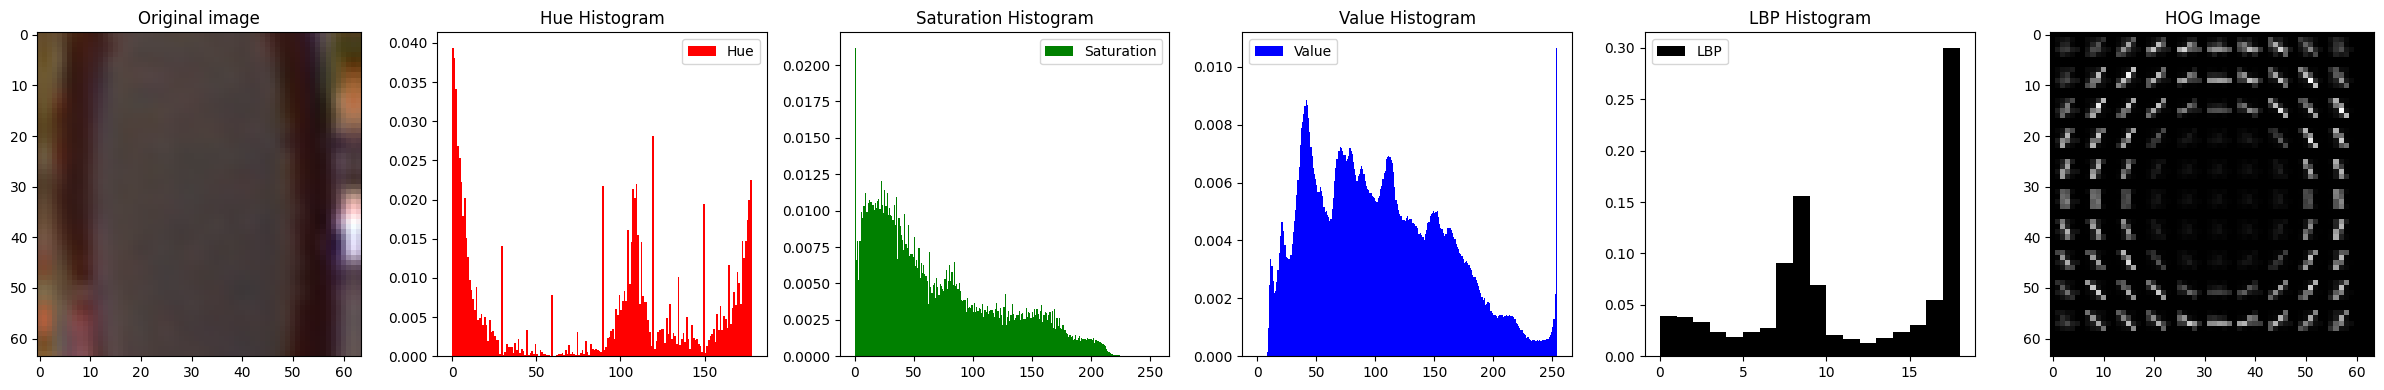

Class 16
Class 16 has samples: 420


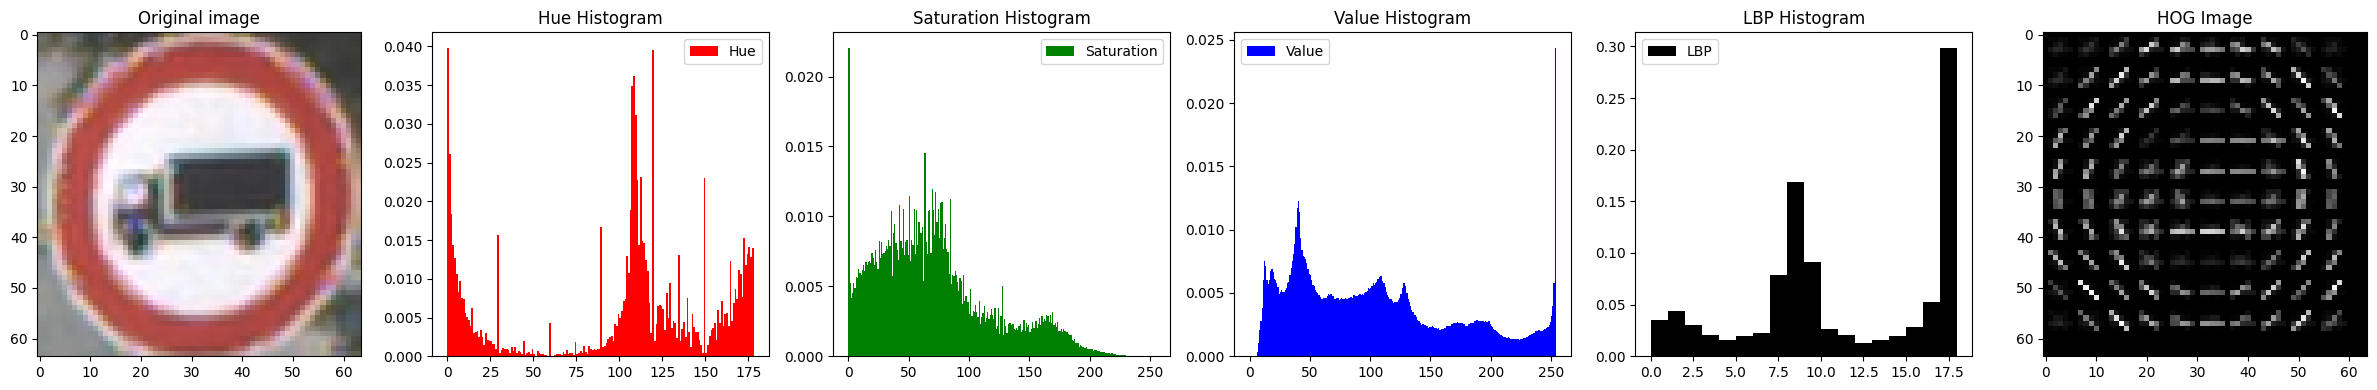

Class 17
Class 17 has samples: 1110


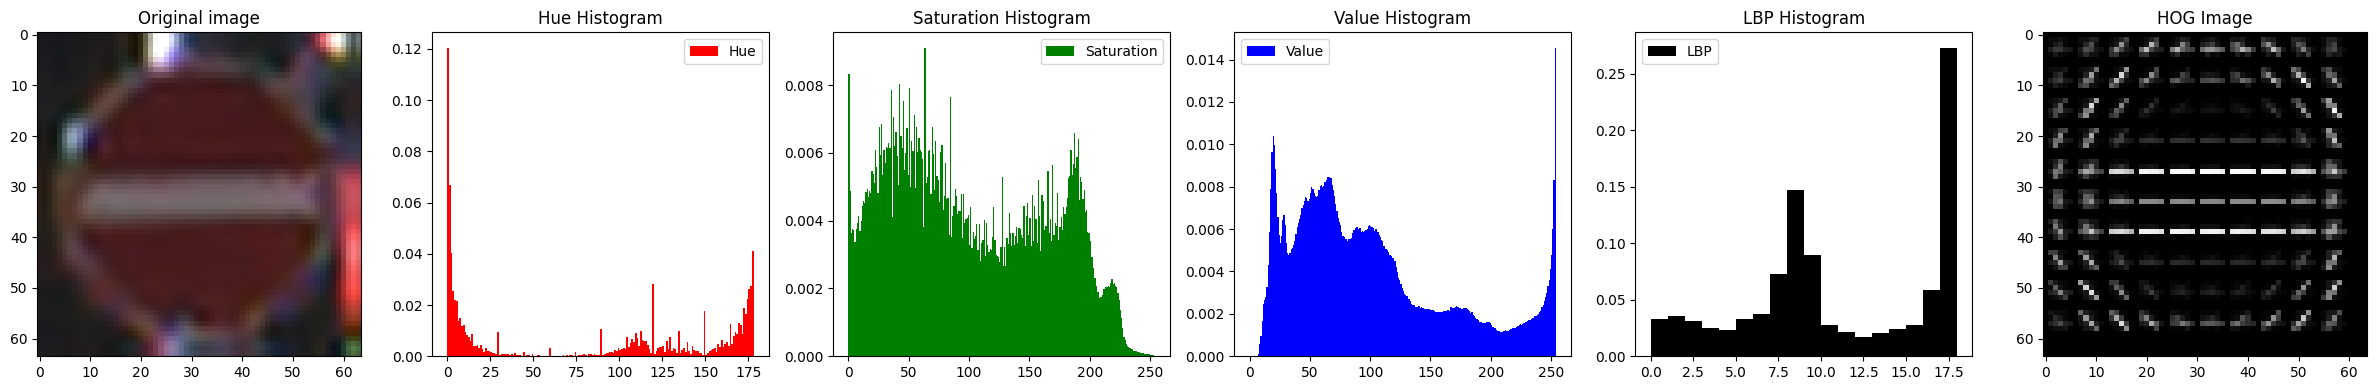

Class 18
Class 18 has samples: 1200


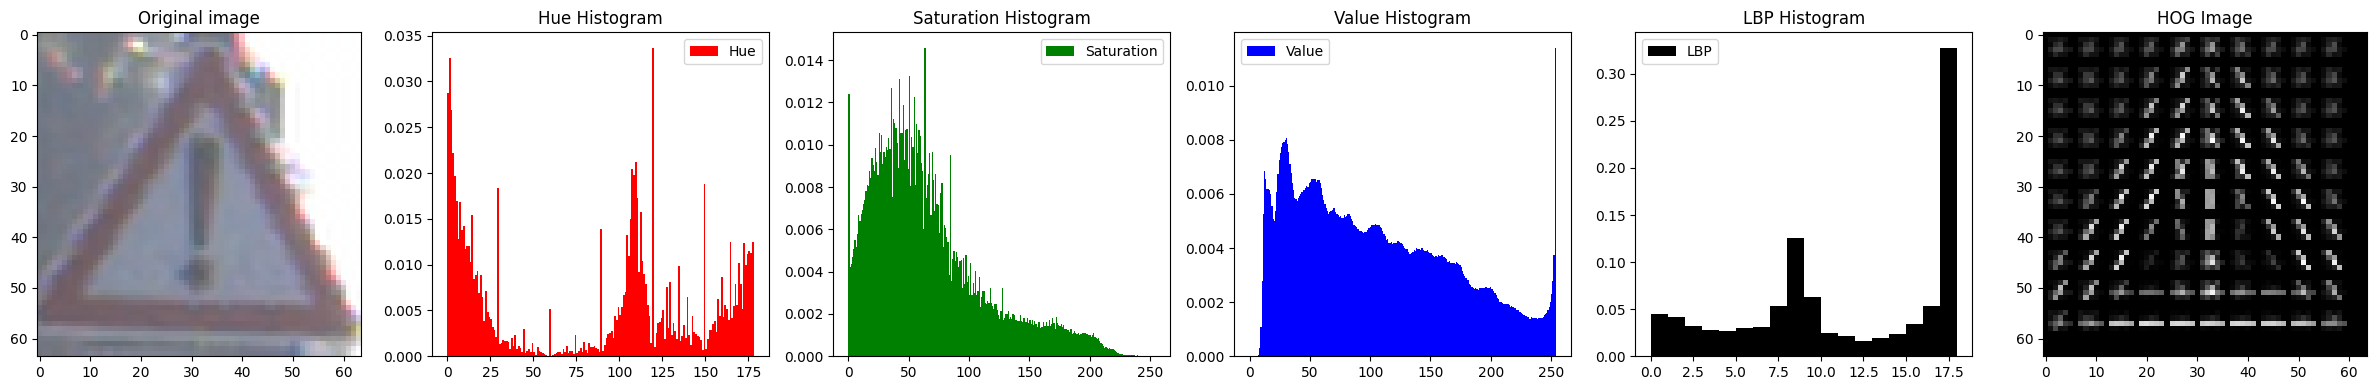

Class 19
Class 19 has samples: 210


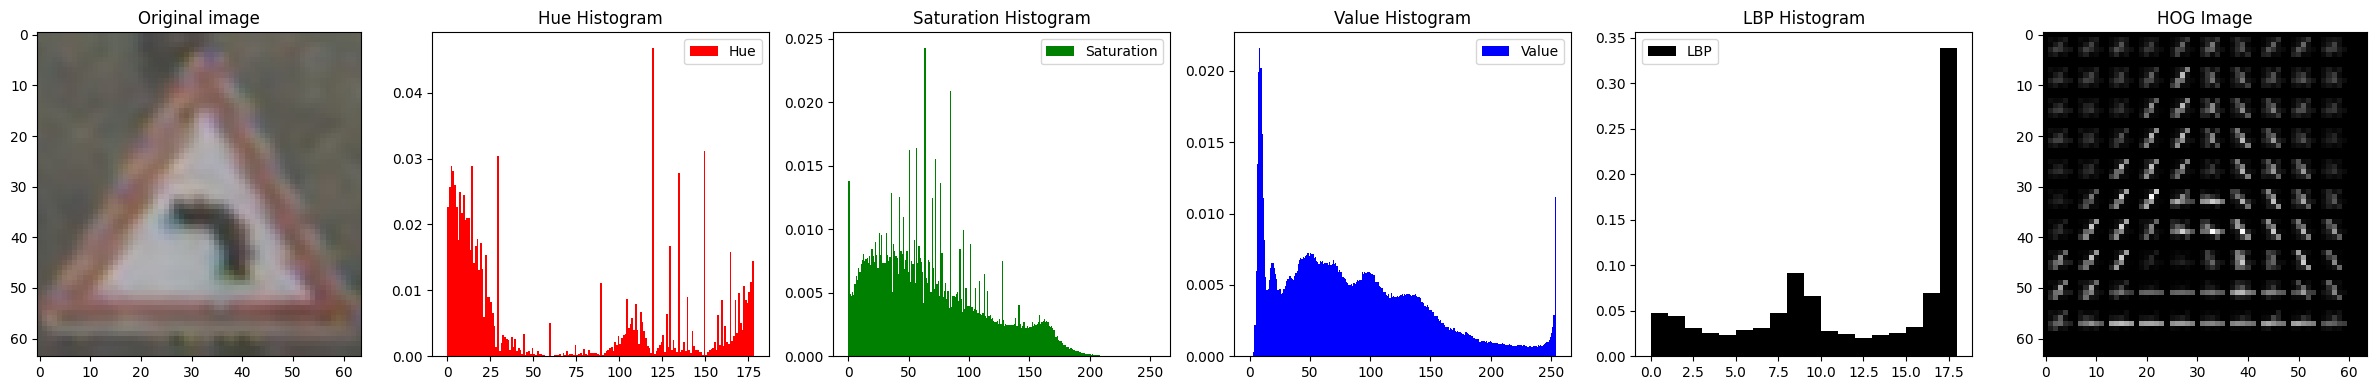

Class 20
Class 20 has samples: 360


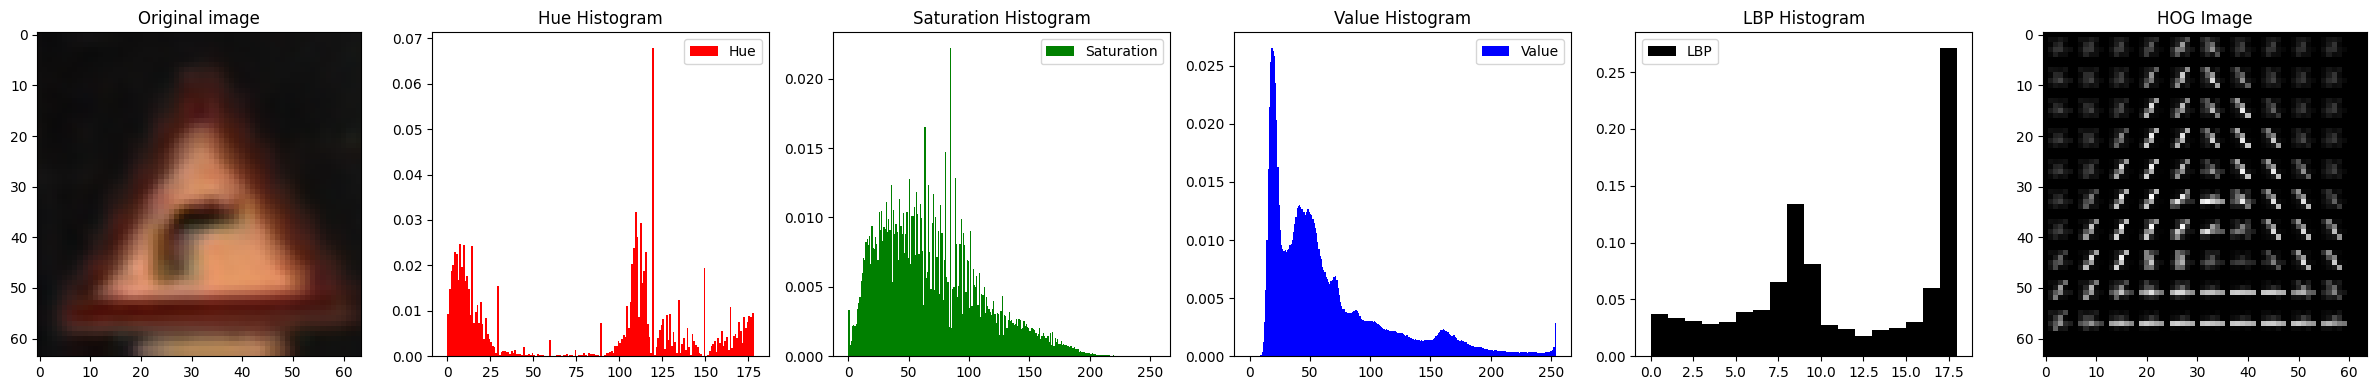

Class 21
Class 21 has samples: 330


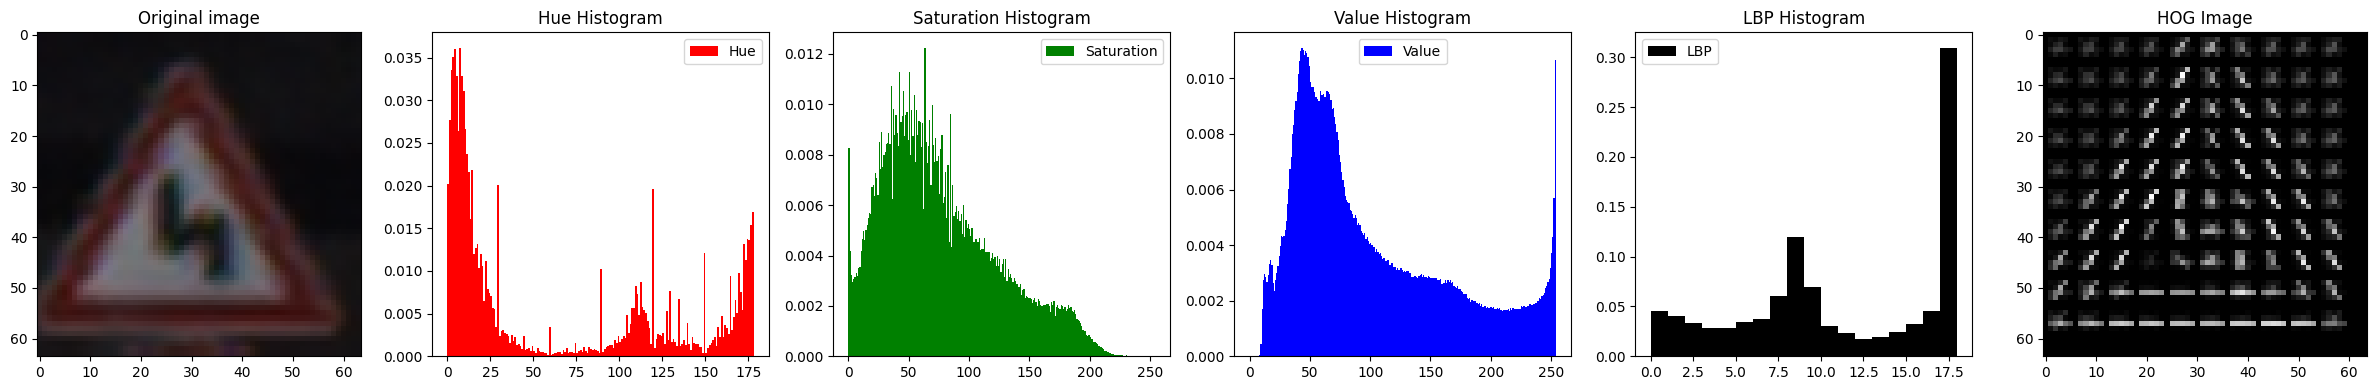

Class 22
Class 22 has samples: 390


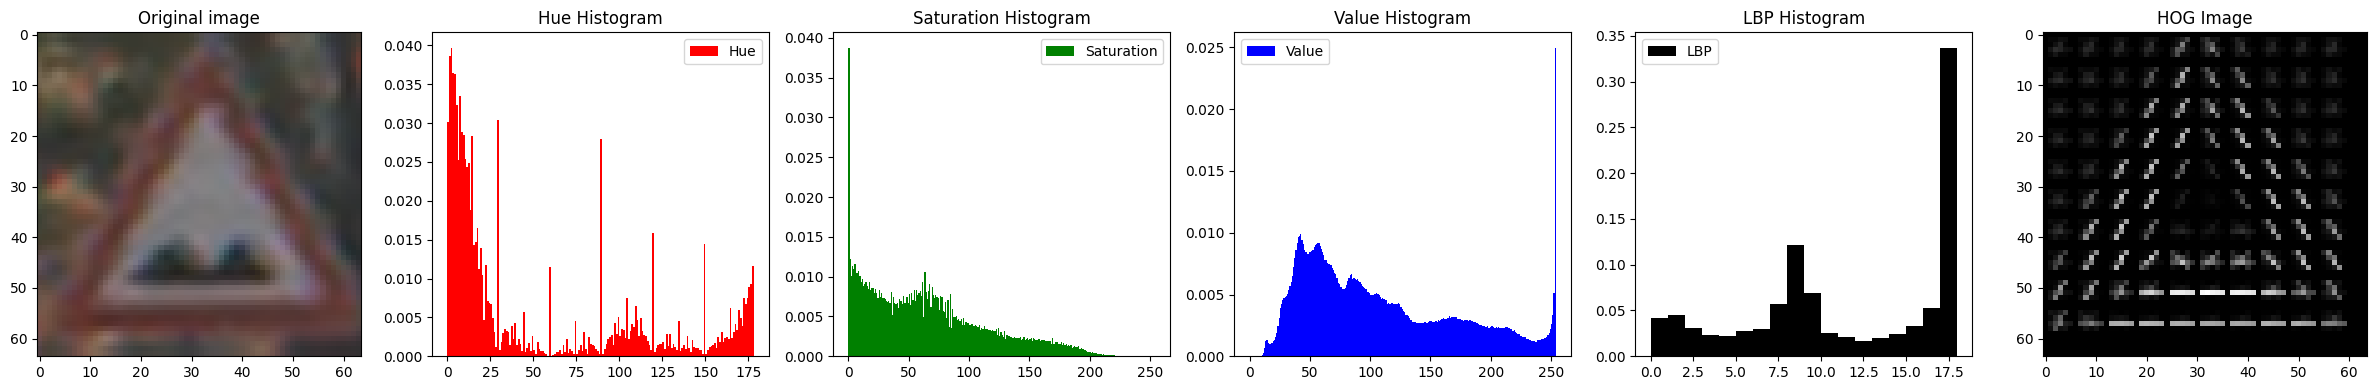

Class 23
Class 23 has samples: 510


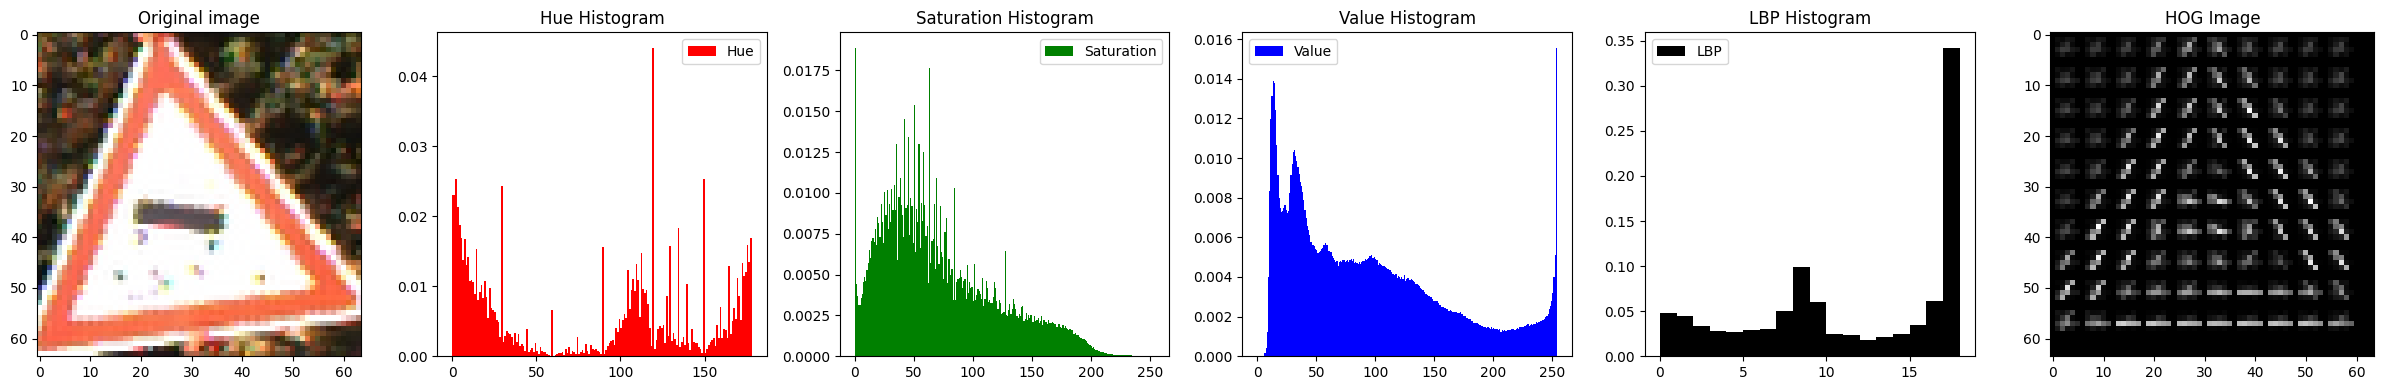

Class 24
Class 24 has samples: 270


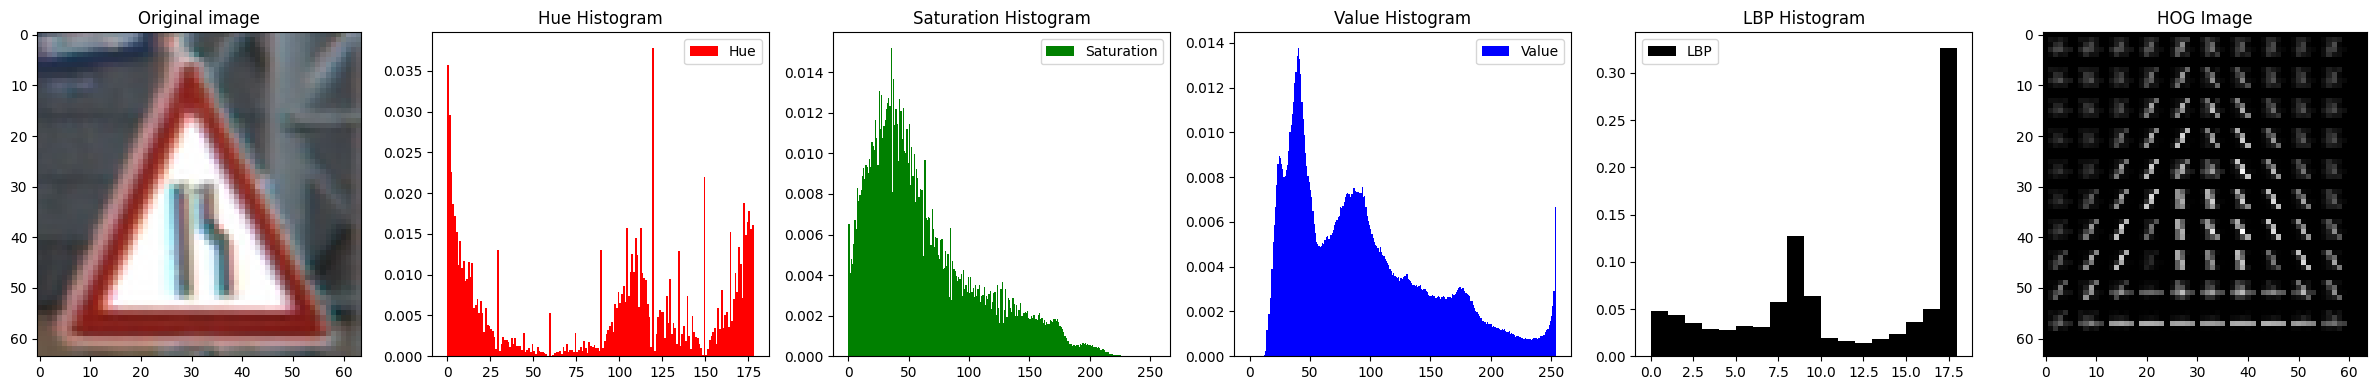

Class 25
Class 25 has samples: 1500


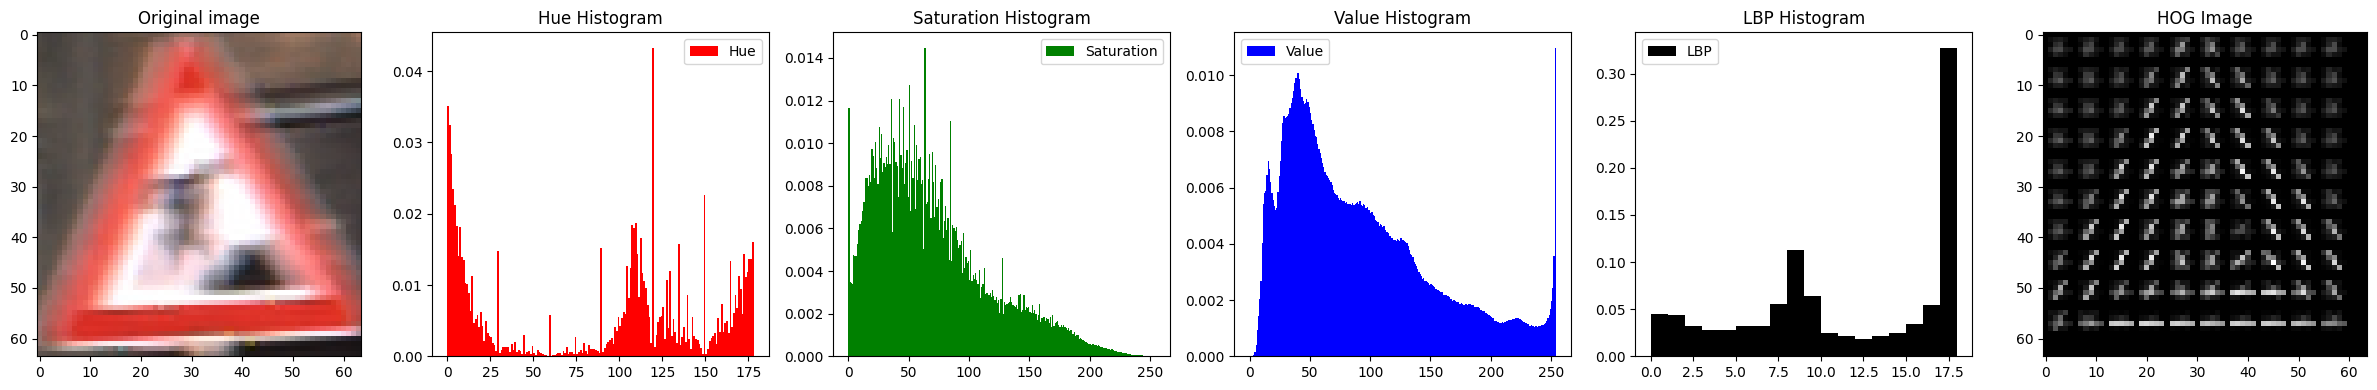

Class 26
Class 26 has samples: 600


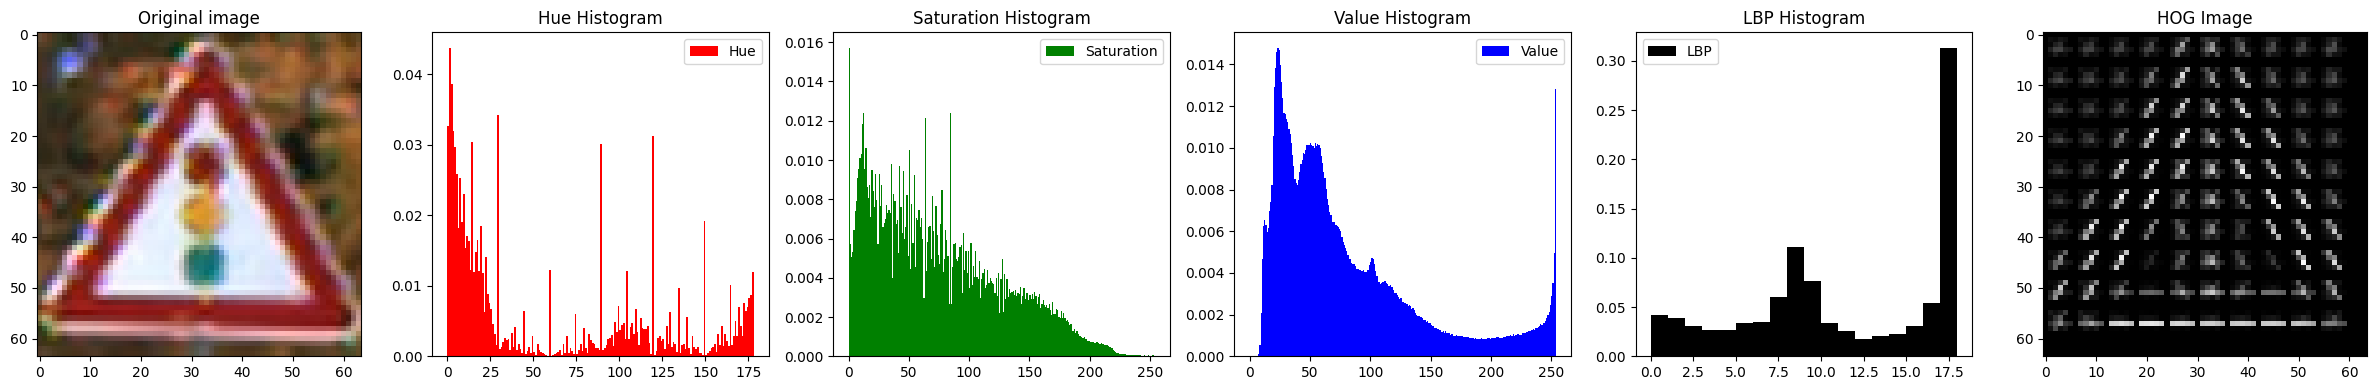

Class 27
Class 27 has samples: 240


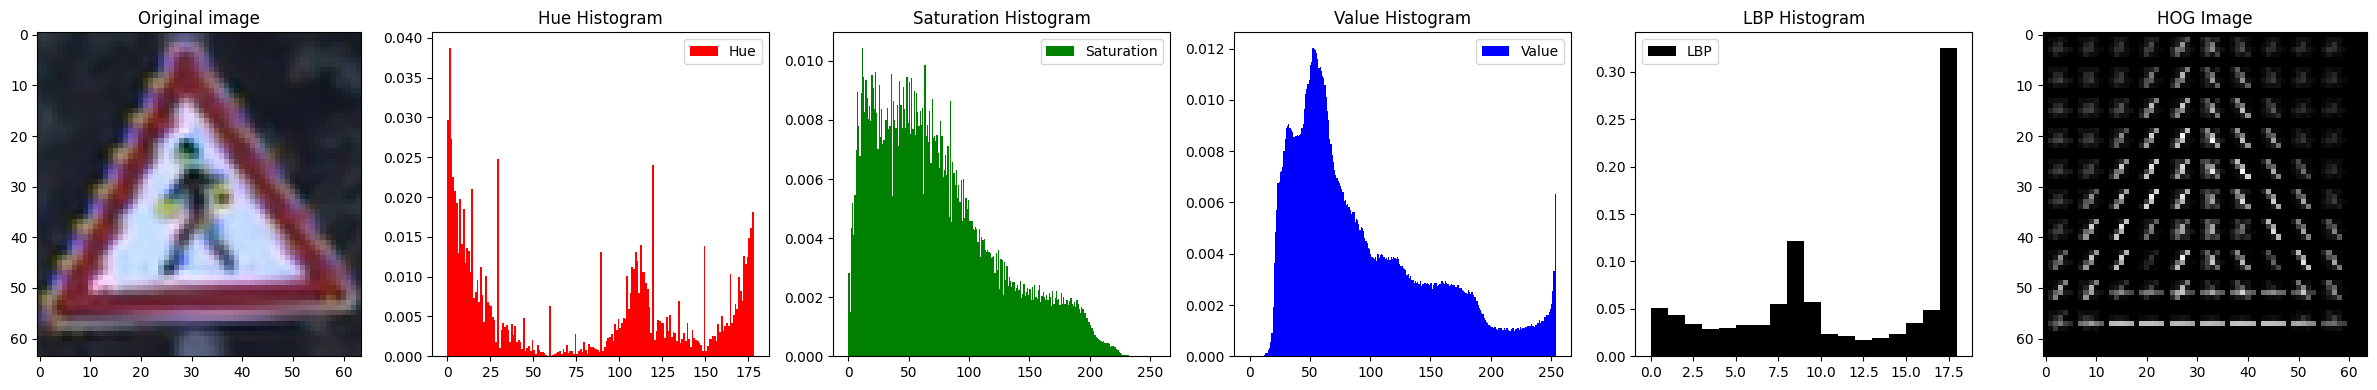

Class 28
Class 28 has samples: 540


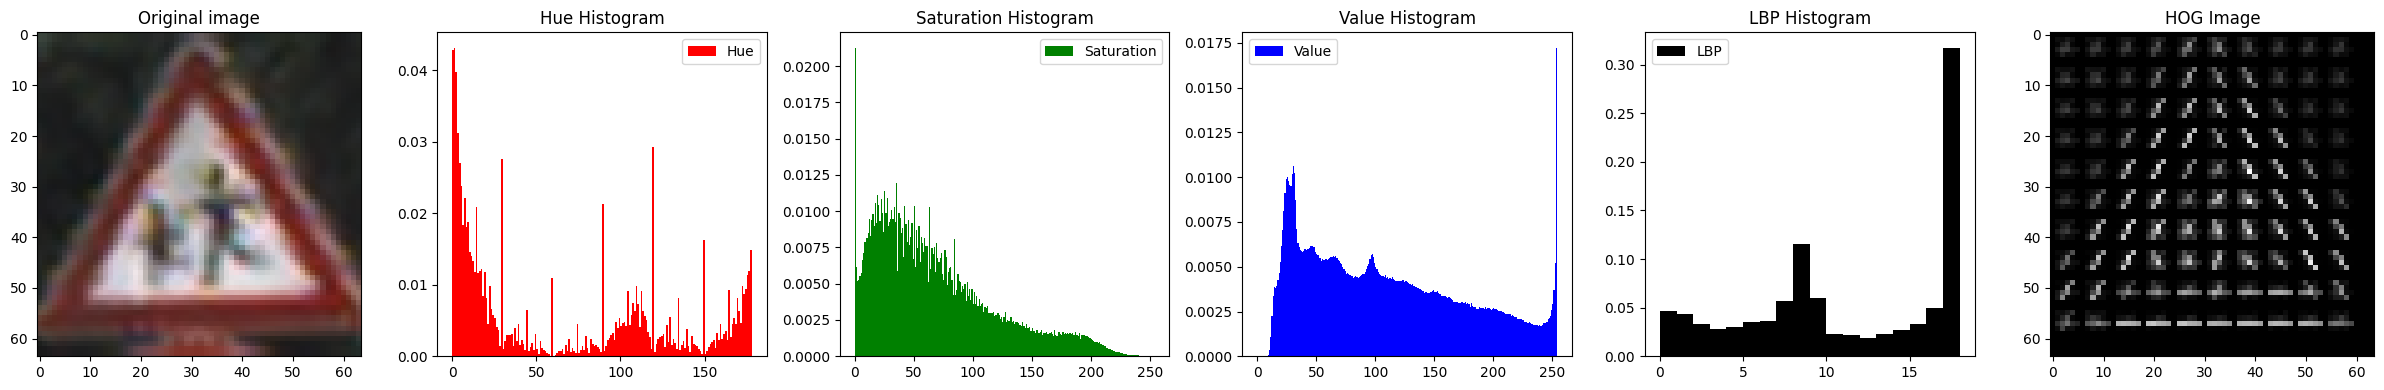

Class 29
Class 29 has samples: 270


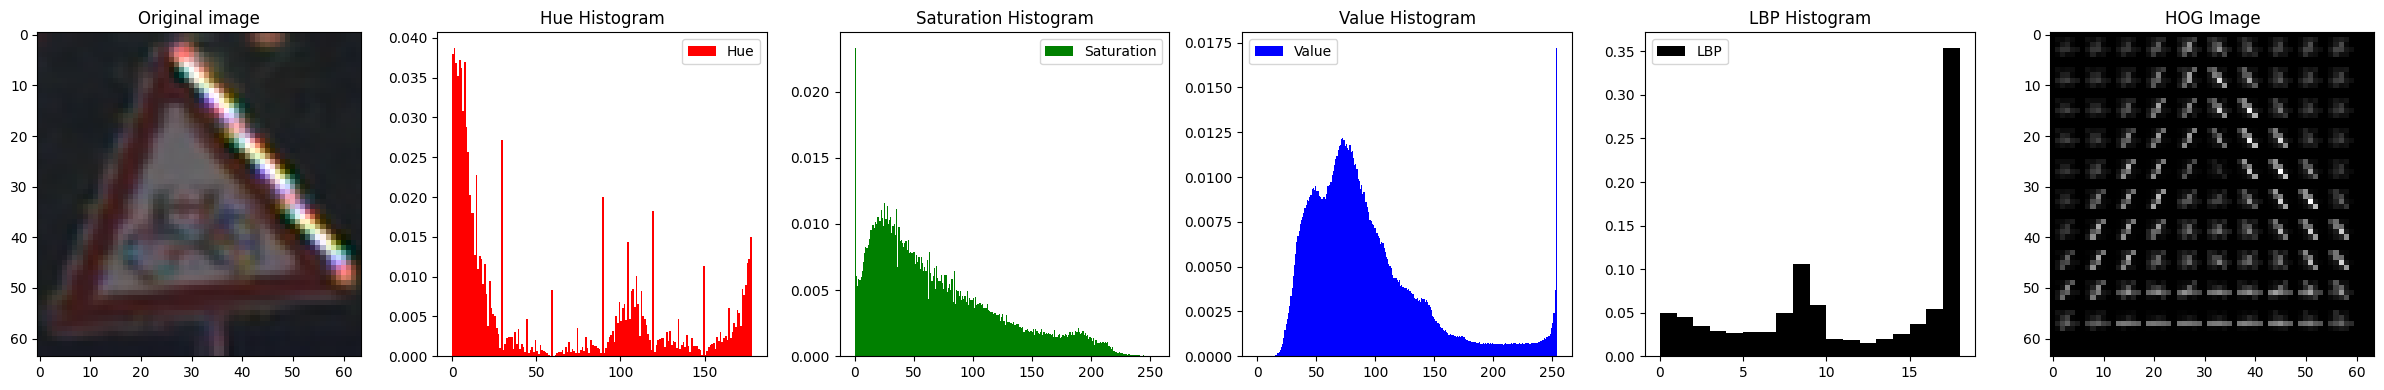

Class 30
Class 30 has samples: 450


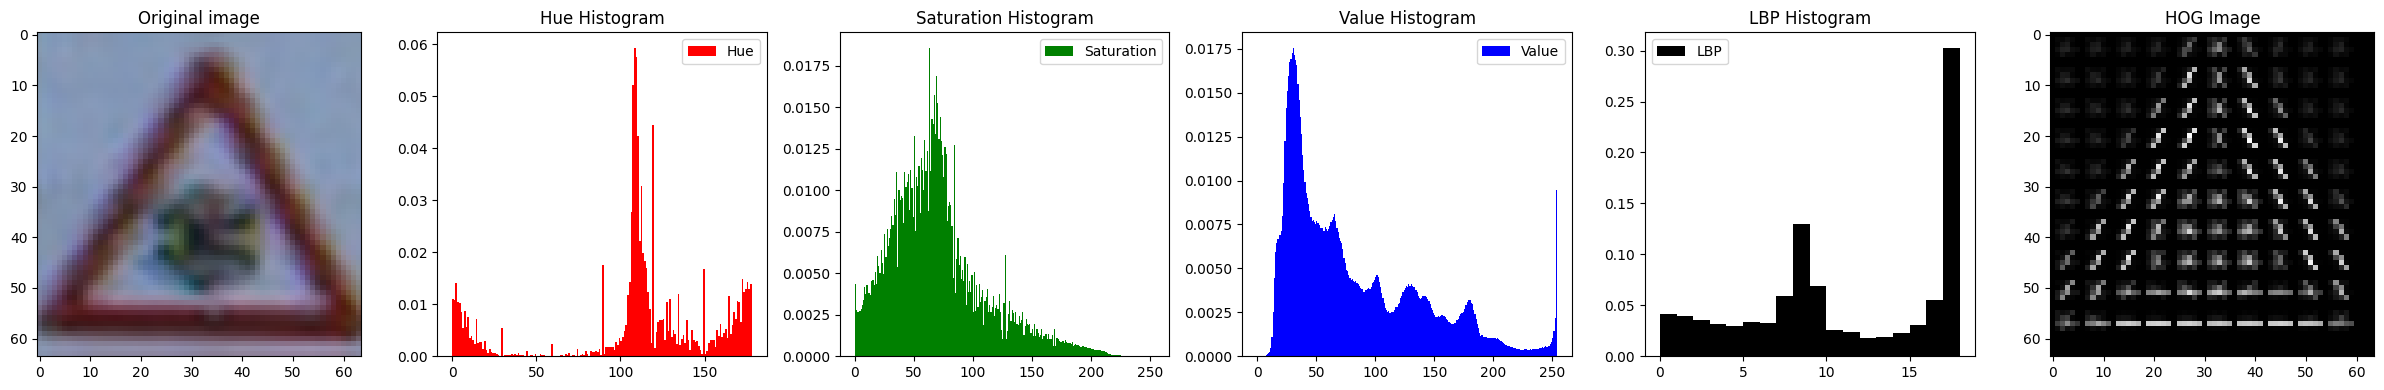

Class 31
Class 31 has samples: 780


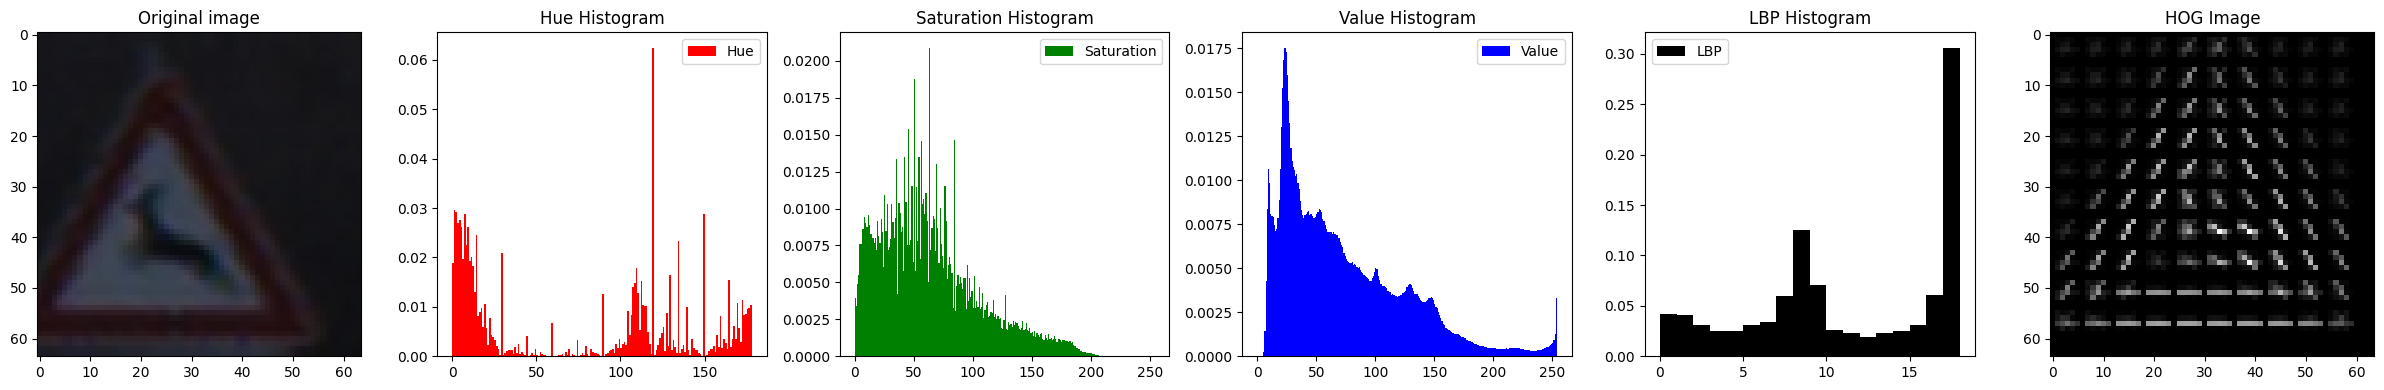

Class 32
Class 32 has samples: 240


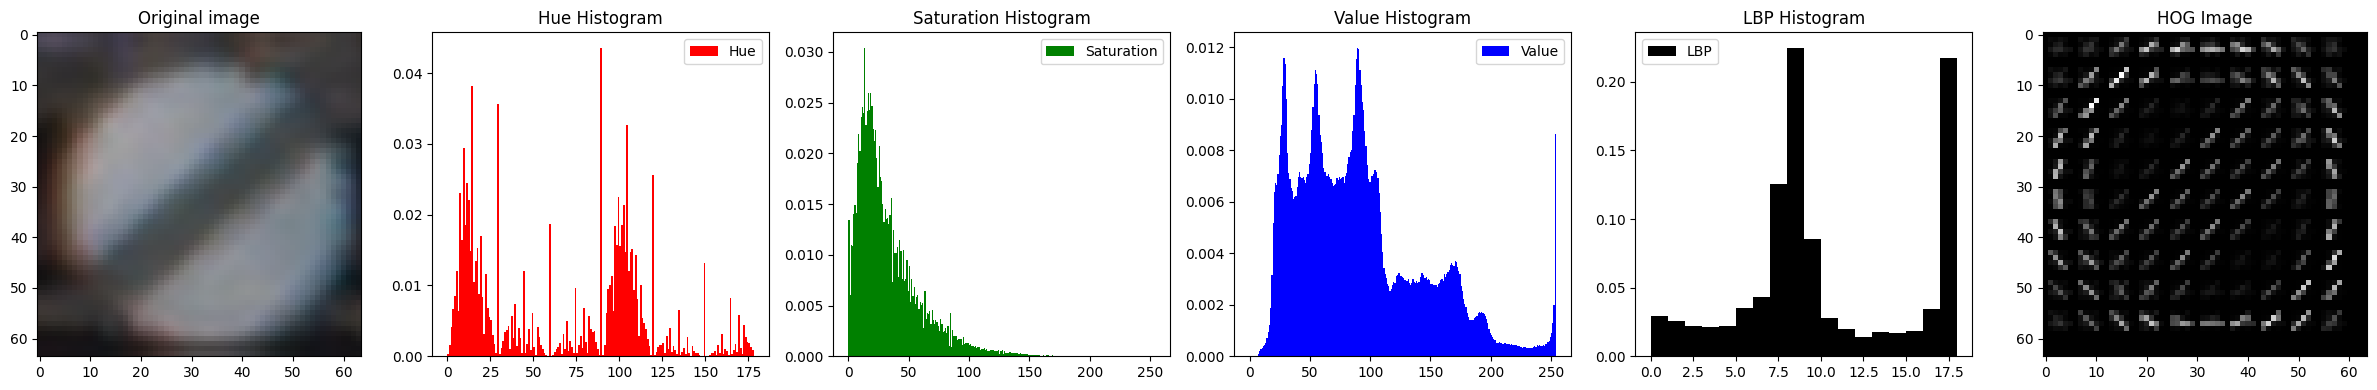

Class 33
Class 33 has samples: 689


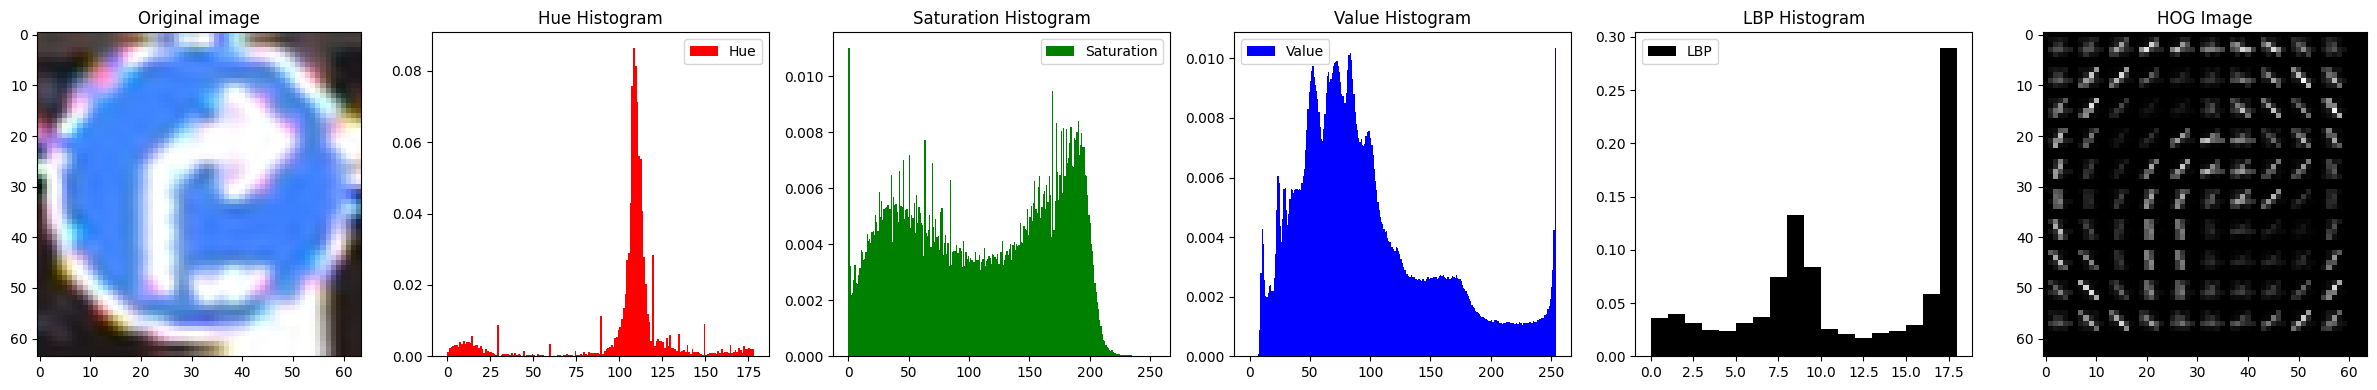

Class 34
Class 34 has samples: 420


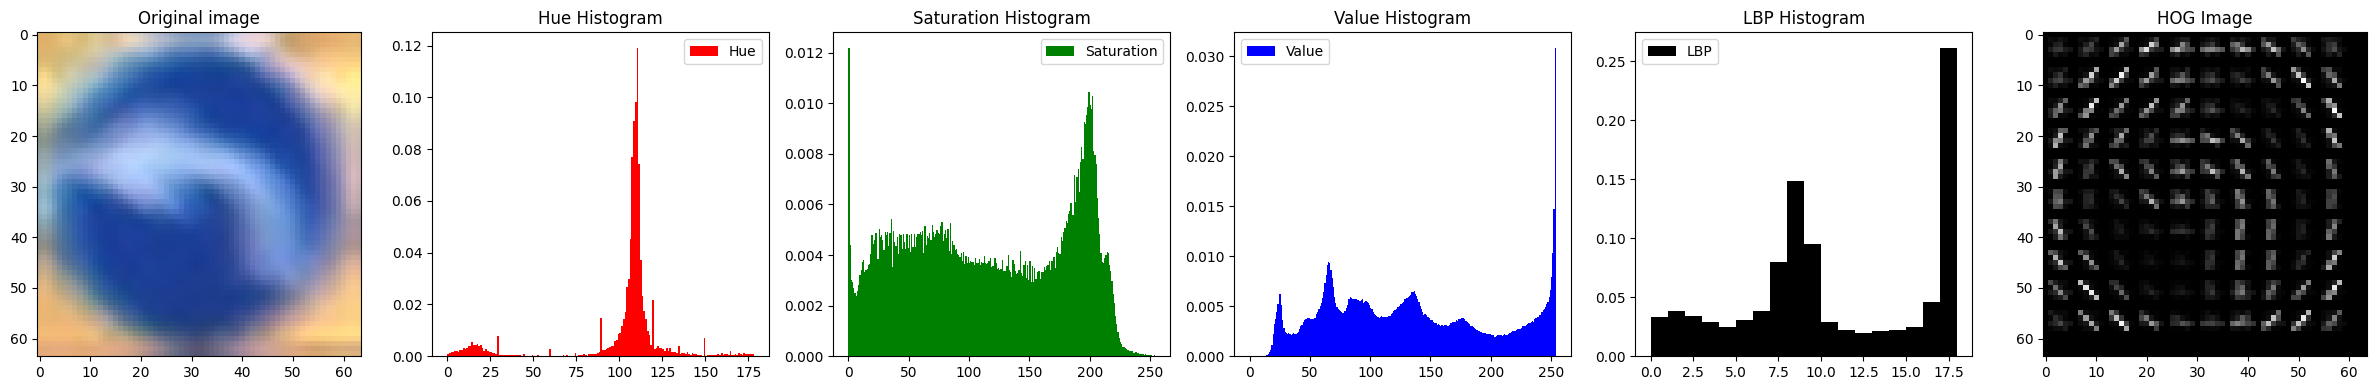

Class 35
Class 35 has samples: 1200


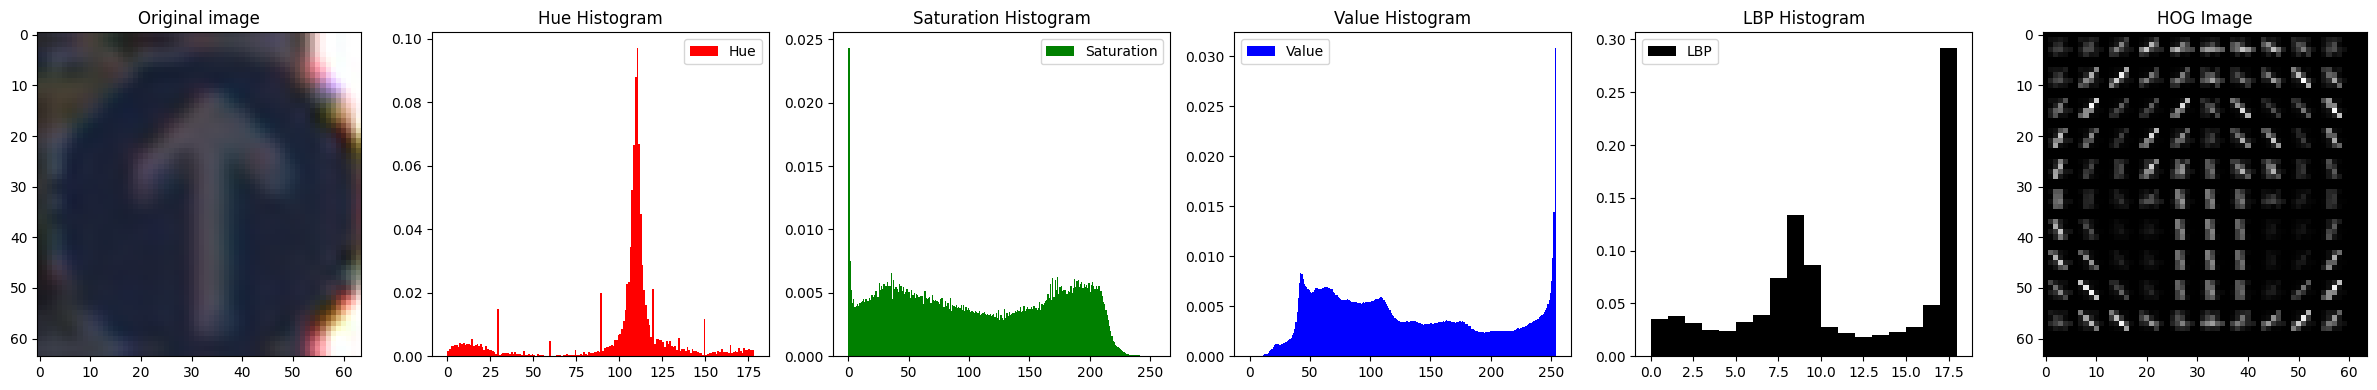

Class 36
Class 36 has samples: 390


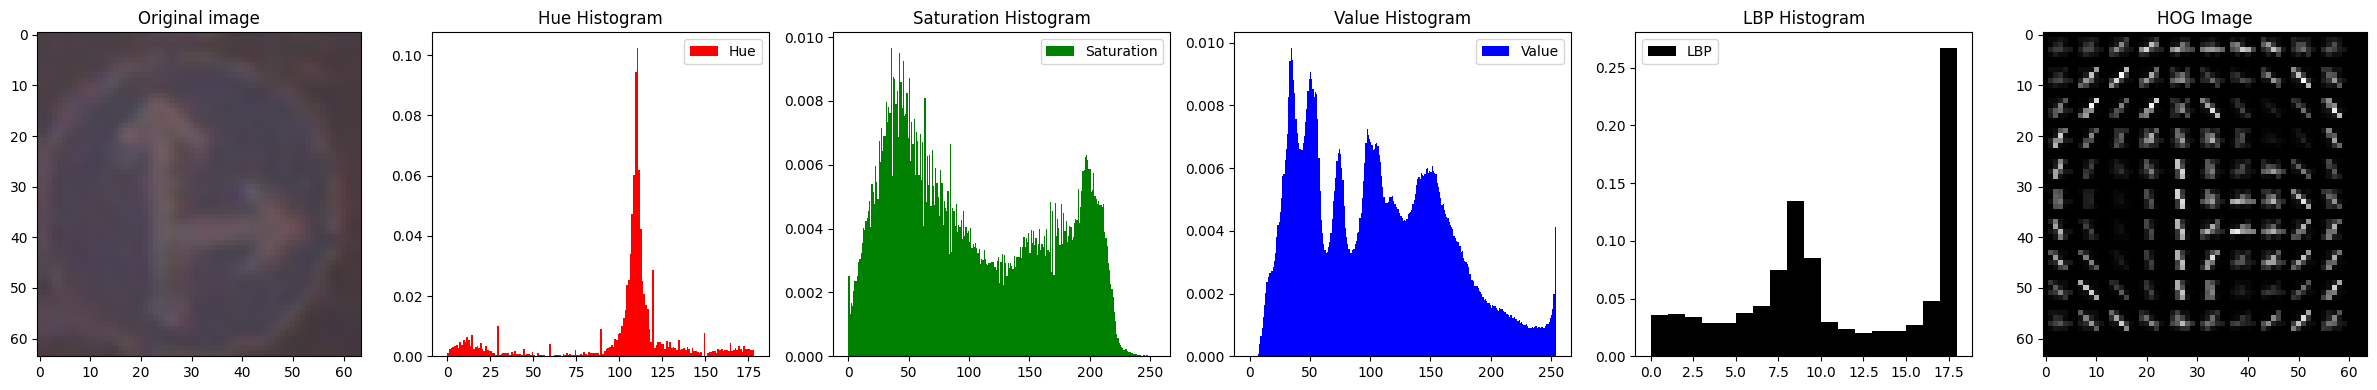

Class 37
Class 37 has samples: 210


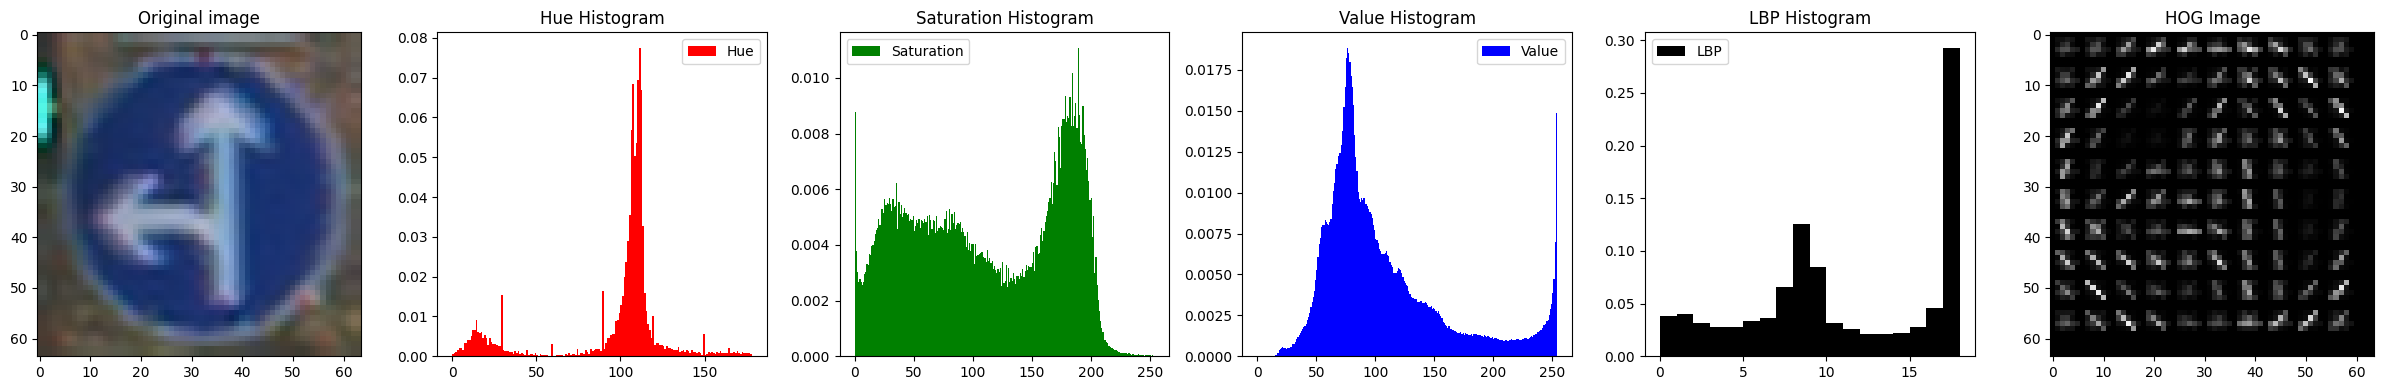

Class 38
Class 38 has samples: 2070


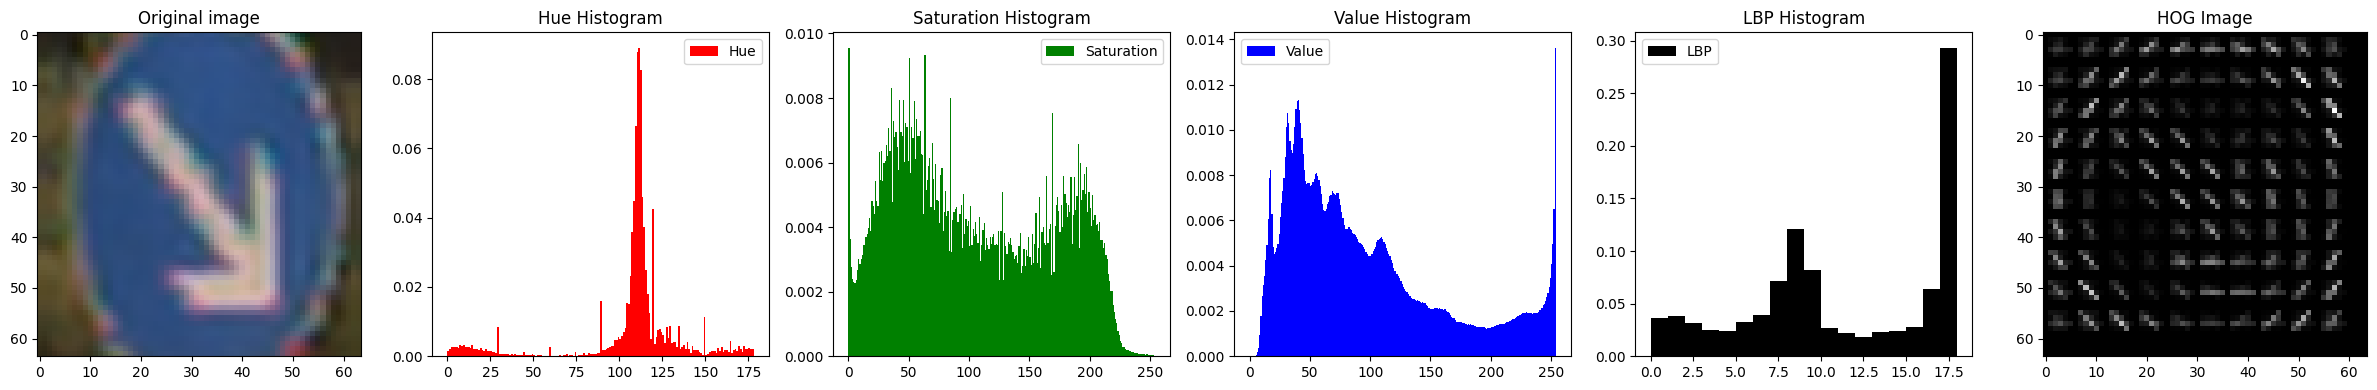

Class 39
Class 39 has samples: 300


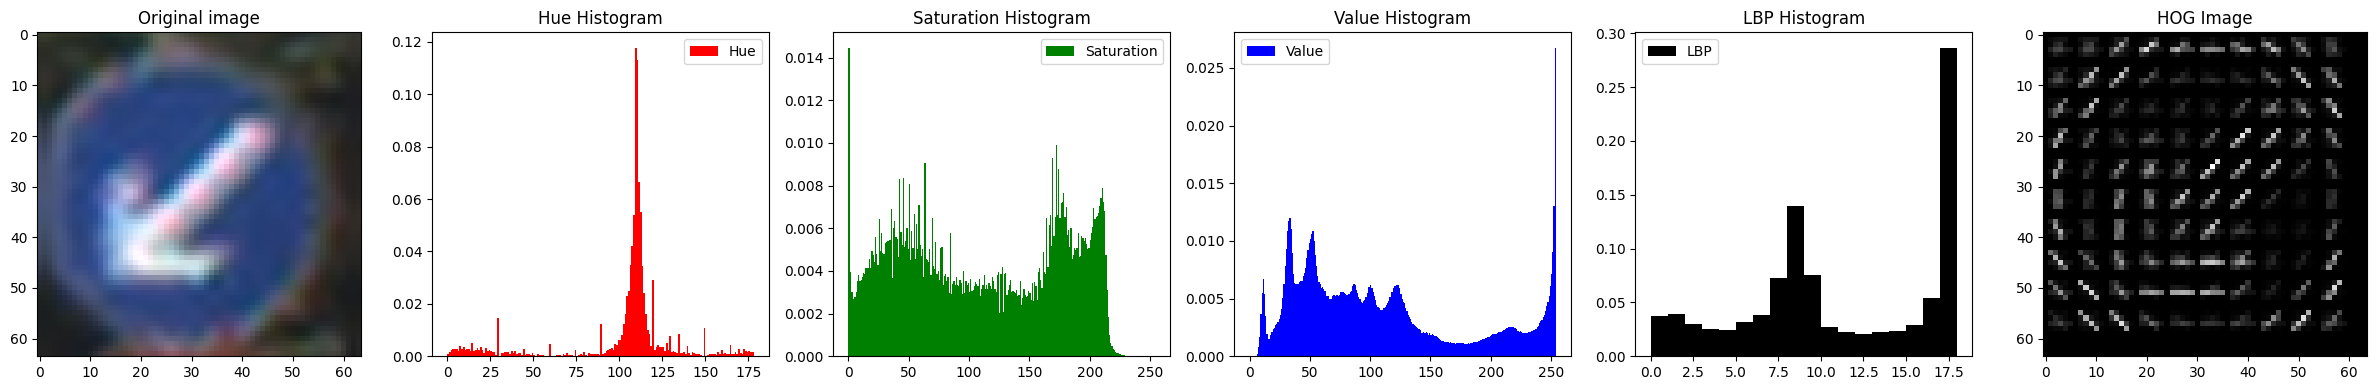

Class 40
Class 40 has samples: 360


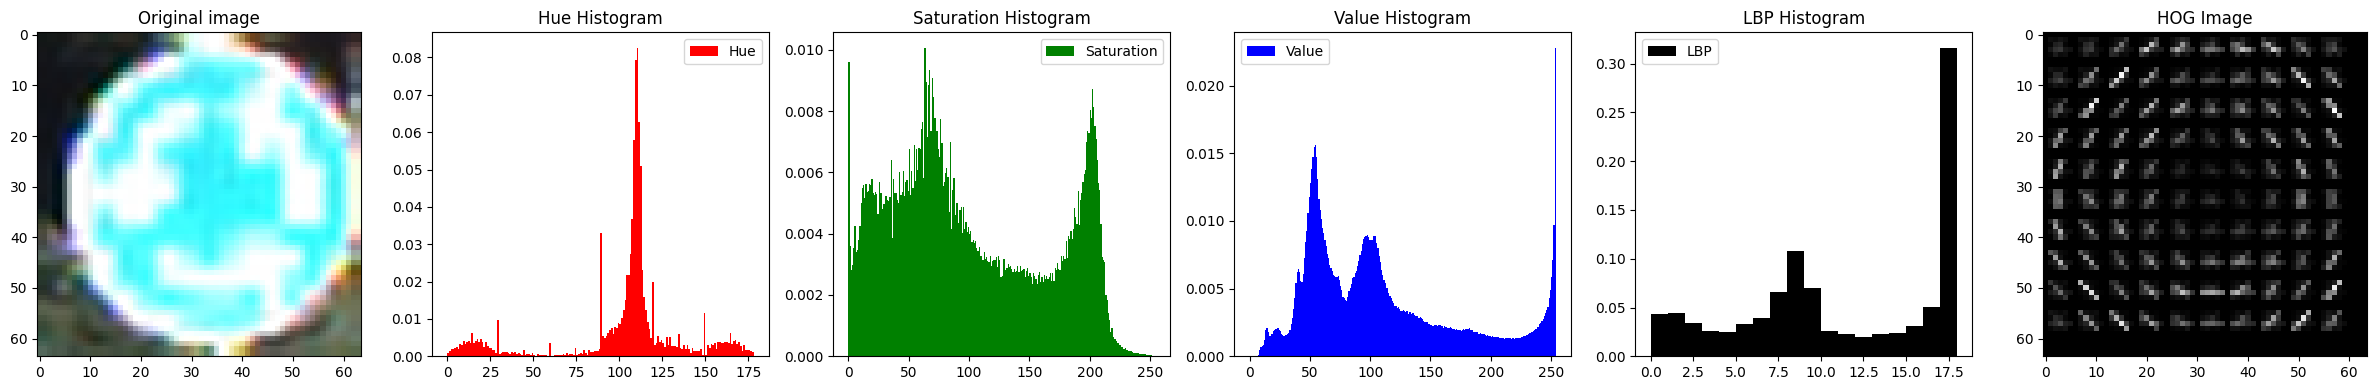

Class 41
Class 41 has samples: 240


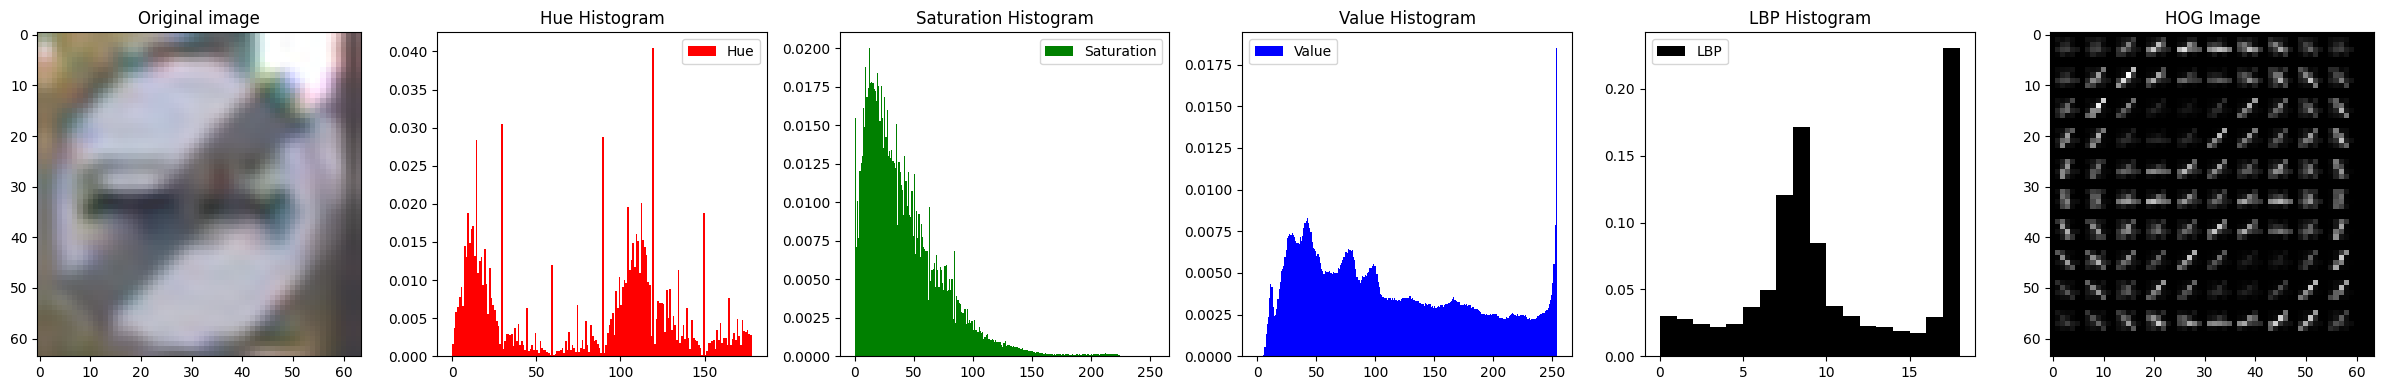

Class 42
Class 42 has samples: 240


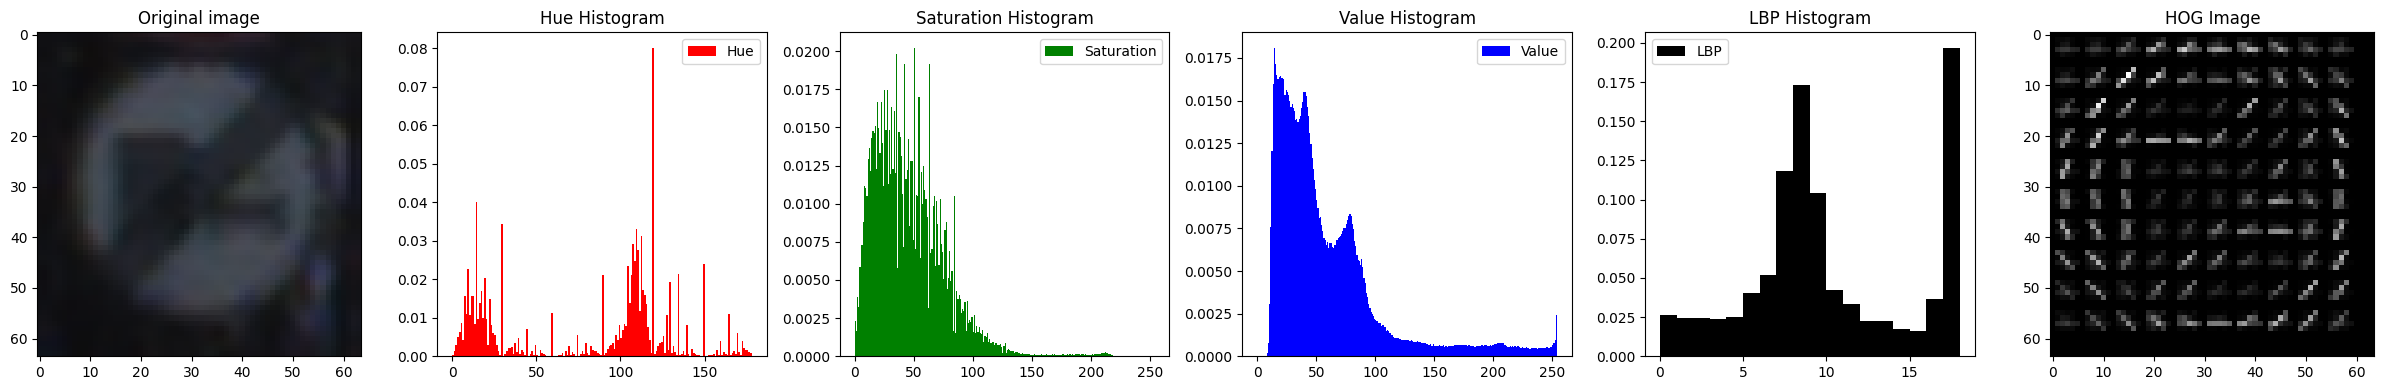

In [5]:
# This is the slow way to iterate through a dataframe
h_ymin = 0
h_ymax = (
    0.15  # This will clip some high values but provide better overall visualization
)
random_seed = 42
num_samples_per_class = 5

for i in range(43):
    class_members = dft.filter(pl.col("ClassId") == i)

    print(100 * "=")
    print(f"Class {i}")
    print(f"Class {i} has samples: {class_members.height}")
    for j, sample in enumerate(class_members.iter_rows(named=True)):
        if j == 0:
            stacked_hue_hist = np.asarray(sample["Hue_Hist"])
            stacked_sat_hist = np.asarray(sample["Saturation_Hist"])
            stacked_val_hist = np.asarray(sample["Value_Hist"])
            stacked_lbp_hist = np.asarray(sample["LBP_Hist"])
            stacked_hog_image = np.load(BytesIO(sample["HOG_Image"]))
        else:
            stacked_hue_hist = np.dstack(
                (stacked_hue_hist, np.asarray(sample["Hue_Hist"]))
            )
            stacked_sat_hist = np.dstack(
                (stacked_sat_hist, np.asarray(sample["Saturation_Hist"]))
            )
            stacked_val_hist = np.dstack(
                (stacked_val_hist, np.asarray(sample["Value_Hist"]))
            )
            stacked_lbp_hist = np.dstack(
                (stacked_lbp_hist, np.asarray(sample["LBP_Hist"]))
            )
            stacked_hog_image = np.dstack(
                (stacked_hog_image, np.load(BytesIO(sample["HOG_Image"])))
            )

    class_mean_hue_hist = np.mean(np.squeeze(stacked_hue_hist), axis=1)
    class_mean_hue_hist = class_mean_hue_hist[1:-1]
    class_mean_hue_edges = np.histogram_bin_edges(
        class_mean_hue_hist, bins=178, range=(0, 178)
    )
    class_mean_hue_centers = 0.5 * (
        class_mean_hue_edges[1:] + class_mean_hue_edges[:-1]
    )

    class_mean_sat_hist = np.mean(np.squeeze(stacked_sat_hist), axis=1)
    class_mean_sat_hist = class_mean_sat_hist[1:-1]
    class_mean_sat_edges = np.histogram_bin_edges(
        class_mean_sat_hist, bins=254, range=(0, 254)
    )
    class_mean_sat_centers = 0.5 * (
        class_mean_sat_edges[1:] + class_mean_sat_edges[:-1]
    )

    class_mean_val_hist = np.mean(np.squeeze(stacked_val_hist), axis=1)
    class_mean_val_hist = class_mean_val_hist[1:-1]
    class_mean_val_edges = np.histogram_bin_edges(
        class_mean_val_hist, bins=254, range=(0, 254)
    )
    class_mean_val_centers = 0.5 * (
        class_mean_val_edges[1:] + class_mean_val_edges[:-1]
    )

    class_mean_lbp_hist = np.mean(np.squeeze(stacked_lbp_hist), axis=1)
    class_mean_lbp_edges = np.histogram_bin_edges(
        class_mean_lbp_hist,
        bins=len(class_mean_lbp_hist),
        range=(0, len(class_mean_lbp_hist)),
    )
    class_mean_lbp_centers = 0.5 * (
        class_mean_lbp_edges[1:] + class_mean_lbp_edges[:-1]
    )

    class_mean_hog_image = np.mean(np.squeeze(stacked_hog_image), axis=2)

    # Plot original image
    nrows = 1
    ncols = 6
    fig = plt.figure(figsize=(24, 4))

    original_image = np.load(BytesIO(class_members["Image"][random_seed]))
    original_image = (original_image * 255).astype(np.uint8)
    ax = fig.add_subplot(nrows, ncols, 1)
    ax.imshow(original_image)
    ax.set_title("Original image")

    ax = fig.add_subplot(nrows, ncols, 2)
    plt.bar(
        class_mean_hue_centers,
        normalize_histogram(class_mean_hue_hist),
        width=(class_mean_hue_edges[1] - class_mean_hue_edges[0]),
        color="red",
        label="Hue",
    )
    ax.legend()
    ax.set_title("Hue Histogram")
    del class_mean_hue_hist
    del class_mean_hue_edges
    del class_mean_hue_centers

    ax = fig.add_subplot(nrows, ncols, 3)
    plt.bar(
        class_mean_sat_centers,
        normalize_histogram(class_mean_sat_hist),
        width=(class_mean_sat_edges[1] - class_mean_sat_edges[0]),
        color="green",
        label="Saturation",
    )
    ax.legend()
    ax.set_title("Saturation Histogram")
    del class_mean_sat_hist
    del class_mean_sat_edges
    del class_mean_sat_centers

    ax = fig.add_subplot(nrows, ncols, 4)
    plt.bar(
        class_mean_val_centers,
        normalize_histogram(class_mean_val_hist),
        width=(class_mean_val_edges[1] - class_mean_val_edges[0]),
        color="blue",
        label="Value",
    )
    ax.legend()
    ax.set_title("Value Histogram")
    del class_mean_val_hist
    del class_mean_val_edges
    del class_mean_val_centers

    ax = fig.add_subplot(nrows, ncols, 5)
    plt.bar(
        class_mean_lbp_centers,
        normalize_histogram(class_mean_lbp_hist),
        width=(class_mean_lbp_edges[1] - class_mean_lbp_edges[0]),
        color="black",
        label="LBP",
    )
    ax.legend()
    ax.set_title("LBP Histogram")
    del class_mean_lbp_hist
    del class_mean_lbp_edges
    del class_mean_lbp_centers

    ax = fig.add_subplot(nrows, ncols, 6)
    ax.imshow(class_mean_hog_image, cmap="gray")
    ax.set_title("HOG Image")

    plt.tight_layout()
    plt.show()